In [1]:
# Import all necessary libraries and the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import sys
import warnings
warnings.filterwarnings('ignore')
from nba_analysis_functions import *
%matplotlib inline

df = pd.read_csv('nba_team_stats_01_to_24.csv')
df.head()

,teamstatspk,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24


In [2]:
# Drop teamstatspk column
df.drop('teamstatspk', axis=1, inplace=True)

In [3]:
# Modify the season column to be the last 2 digits of the season year
df['season'] = df['season'].str[-2:].astype(int)

In [4]:
# Visually inspect the data for anomolies
df.describe()

,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,three_pointers_made,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,...,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.00000,716.000000,716.000000
mean,80.430168,40.215084,40.215084,0.499784,3888.927374,8230.385475,3062.220670,6716.244413,45.573743,654.132682,...,3439.062849,1812.224860,1155.023743,609.410615,393.428771,393.428771,1668.815642,1303.78352,0.000000,12.555866
std,4.286506,12.215024,12.133228,0.148919,207.684720,712.154467,251.252302,446.747528,1.686295,244.858190,...,232.258935,209.520421,111.140487,73.742012,67.002488,59.046211,175.680398,674.01655,366.105682,6.905229
min,64.000000,7.000000,9.000000,0.106000,3112.000000,5739.000000,2193.000000,5086.000000,40.800000,214.000000,...,2560.000000,1224.000000,738.000000,390.000000,195.000000,245.000000,1109.000000,0.00000,-918.000000,1.000000
25%,82.000000,32.000000,31.000000,0.390000,3951.000000,7838.500000,2931.750000,6490.750000,44.400000,466.000000,...,3325.000000,1680.000000,1086.000000,559.750000,345.000000,352.750000,1562.500000,1331.75000,-248.000000,7.000000
50%,82.000000,41.000000,39.000000,0.512000,3961.000000,8182.500000,3050.500000,6724.000000,45.500000,606.000000,...,3459.500000,1795.500000,1157.000000,605.000000,388.000000,392.500000,1676.000000,1604.00000,19.000000,13.000000
75%,82.000000,49.000000,49.000000,0.610000,3971.000000,8641.500000,3208.500000,7018.000000,46.700000,845.500000,...,3585.250000,1933.500000,1224.000000,657.000000,439.250000,431.000000,1786.000000,1708.00000,266.000000,19.000000
max,82.000000,73.000000,72.000000,0.890000,4016.000000,10110.000000,3855.000000,7739.000000,50.700000,1363.000000,...,4078.000000,2522.000000,1514.000000,844.000000,624.000000,565.000000,2189.000000,2104.00000,954.000000,24.000000


In [5]:
# Ensure there is no missing data and that all columns are of the correct data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      716 non-null    object 
 1   games_played              716 non-null    int64  
 2   wins                      716 non-null    int64  
 3   losses                    716 non-null    int64  
 4   win_percentage            716 non-null    float64
 5   Min                       716 non-null    int64  
 6   points                    716 non-null    int64  
 7   field_goals_made          716 non-null    int64  
 8   field_goals_attempted     716 non-null    int64  
 9   field_goal_percentage     716 non-null    float64
 10  three_pointers_made       716 non-null    int64  
 11  three_pointers_attempted  716 non-null    int64  
 12  three_point_percentage    716 non-null    float64
 13  free_throws_made          716 non-null    int64  
 14  free_throw

In [6]:
# Create a copy of the dataframe that will only contain numerical data
df_num = df.copy()

In [7]:
# Drop the only non-numeric data type from the dataframe as well as features that will not be used for analysis
df_num.drop(['Team', 'games_played', 'wins', 'losses', 'Min'], axis=1, inplace=True)

In [8]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [9]:
df_num['points'].describe()

count      716.000000
mean      8230.385475
std        712.154467
min       5739.000000
25%       7838.500000
50%       8182.500000
75%       8641.500000
max      10110.000000
Name: points, dtype: float64

In [10]:
df_num['field_goals_made'].describe()

count     716.000000
mean     3062.220670
std       251.252302
min      2193.000000
25%      2931.750000
50%      3050.500000
75%      3208.500000
max      3855.000000
Name: field_goals_made, dtype: float64

In [11]:
df_num['field_goals_attempted'].describe()

count     716.000000
mean     6716.244413
std       446.747528
min      5086.000000
25%      6490.750000
50%      6724.000000
75%      7018.000000
max      7739.000000
Name: field_goals_attempted, dtype: float64

In [12]:
df_num['field_goal_percentage'].describe()

count    716.000000
mean      45.573743
std        1.686295
min       40.800000
25%       44.400000
50%       45.500000
75%       46.700000
max       50.700000
Name: field_goal_percentage, dtype: float64

In [13]:
# Convert field_goal_percentage to a decimal
df_num['field_goal_percentage'] = df_num['field_goal_percentage'] * .01

df_num['field_goal_percentage'].describe()

count    716.000000
mean       0.455737
std        0.016863
min        0.408000
25%        0.444000
50%        0.455000
75%        0.467000
max        0.507000
Name: field_goal_percentage, dtype: float64

In [14]:
df_num['three_pointers_made'].describe()

count     716.000000
mean      654.132682
std       244.858190
min       214.000000
25%       466.000000
50%       606.000000
75%       845.500000
max      1363.000000
Name: three_pointers_made, dtype: float64

In [15]:
df_num['three_pointers_attempted'].describe()

count     716.000000
mean     1828.652235
std       658.066269
min       641.000000
25%      1302.500000
50%      1662.500000
75%      2367.250000
max      3721.000000
Name: three_pointers_attempted, dtype: float64

In [16]:
df_num['three_point_percentage'].describe()

count    716.000000
mean      35.588408
std        1.894185
min       27.800000
25%       34.400000
50%       35.500000
75%       36.900000
max       41.600000
Name: three_point_percentage, dtype: float64

In [17]:
# Convert three_point_percentage to a decimal
df_num['three_point_percentage'] = df_num['three_point_percentage'] * .01

df_num['three_point_percentage'].describe()

count    716.000000
mean       0.355884
std        0.018942
min        0.278000
25%        0.344000
50%        0.355000
75%        0.369000
max        0.416000
Name: three_point_percentage, dtype: float64

In [18]:
df_num['free_throws_made'].describe()

count     716.000000
mean     1451.811453
std       179.820064
min       889.000000
25%      1340.500000
50%      1452.000000
75%      1568.000000
max      1977.000000
Name: free_throws_made, dtype: float64

In [19]:
df_num['free_throw_attempted'].describe()

count     716.000000
mean     1907.463687
std       242.163581
min      1198.000000
25%      1742.250000
50%      1908.000000
75%      2067.250000
max      2587.000000
Name: free_throw_attempted, dtype: float64

In [20]:
df_num['free_throw_percentage'].describe()

count    716.000000
mean      76.198883
std        3.002977
min       66.000000
25%       74.400000
50%       76.300000
75%       78.200000
max       83.900000
Name: free_throw_percentage, dtype: float64

In [21]:
# Convert free_throw_percentage to a decimal
df_num['free_throw_percentage'] = df_num['free_throw_percentage'] * .01

df_num['free_throw_percentage'].describe()

count    716.000000
mean       0.761989
std        0.030030
min        0.660000
25%        0.744000
50%        0.763000
75%        0.782000
max        0.839000
Name: free_throw_percentage, dtype: float64

In [22]:
df_num['offensive_rebounds'].describe()

count     716.000000
mean      881.349162
std       121.544171
min       509.000000
25%       794.000000
50%       886.000000
75%       967.250000
max      1345.000000
Name: offensive_rebounds, dtype: float64

In [23]:
df_num['defensive_rebounds'].describe()

count     716.000000
mean     2557.713687
std       205.076013
min      1879.000000
25%      2439.750000
50%      2555.000000
75%      2701.250000
max      3316.000000
Name: defensive_rebounds, dtype: float64

In [24]:
df_num['rebounds'].describe()

count     716.000000
mean     3439.062849
std       232.258935
min      2560.000000
25%      3325.000000
50%      3459.500000
75%      3585.250000
max      4078.000000
Name: rebounds, dtype: float64

In [25]:
df_num['assists'].describe()

count     716.000000
mean     1812.224860
std       209.520421
min      1224.000000
25%      1680.000000
50%      1795.500000
75%      1933.500000
max      2522.000000
Name: assists, dtype: float64

In [26]:
df_num['turnovers'].describe()

count     716.000000
mean     1155.023743
std       111.140487
min       738.000000
25%      1086.000000
50%      1157.000000
75%      1224.000000
max      1514.000000
Name: turnovers, dtype: float64

In [27]:
df_num['steals'].describe()

count    716.000000
mean     609.410615
std       73.742012
min      390.000000
25%      559.750000
50%      605.000000
75%      657.000000
max      844.000000
Name: steals, dtype: float64

In [28]:
df_num['blocks'].describe()

count    716.000000
mean     393.428771
std       67.002488
min      195.000000
25%      345.000000
50%      388.000000
75%      439.250000
max      624.000000
Name: blocks, dtype: float64

In [29]:
df_num['blocks_attempted'].describe()

count    716.000000
mean     393.428771
std       59.046211
min      245.000000
25%      352.750000
50%      392.500000
75%      431.000000
max      565.000000
Name: blocks_attempted, dtype: float64

In [30]:
df_num['personal_fouls'].describe()

count     716.000000
mean     1668.815642
std       175.680398
min      1109.000000
25%      1562.500000
50%      1676.000000
75%      1786.000000
max      2189.000000
Name: personal_fouls, dtype: float64

In [31]:
df_num['personal_fouls_drawn'].describe()

count     716.00000
mean     1303.78352
std       674.01655
min         0.00000
25%      1331.75000
50%      1604.00000
75%      1708.00000
max      2104.00000
Name: personal_fouls_drawn, dtype: float64

In [32]:
# Upon inspection of the dataset, there are 147 rows that contain less than 20 fouls drawn. This indicates incomplete data, so drop the feature
df_num = df_num.drop(['personal_fouls_drawn'], axis=1)

df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [33]:
# Calculate advanced statistics

In [34]:
# Calculate assist to turnover ratio
df_num['ast_to_ratio'] = df_num['assists'] / df_num['turnovers']

# Calculate the total points from free throws
df_num['points_from_free_throws'] = df_num['free_throws_made']

# Calculate the percentage of points from free throws
df_num['pct_pts_fts'] = (df_num['points_from_free_throws'] / df_num['points'])

# Calculate the assist to field goal ratio
df_num['ast_fg_ratio'] = df_num['assists'] / df_num['field_goals_made']

# Calculate the effective field goal percentage
df_num['eFG%'] = (df_num['field_goals_made'] + 0.5 * df_num['three_pointers_made']) / df_num['field_goals_attempted']

In [35]:
# Inspect the advanced statistics

In [36]:
df_num['ast_to_ratio'].describe()

count    716.000000
mean       1.581596
std        0.224416
min        1.013112
25%        1.425834
50%        1.564107
75%        1.728375
max        2.381492
Name: ast_to_ratio, dtype: float64

In [37]:
df_num['points_from_free_throws'].describe()

count     716.000000
mean     1451.811453
std       179.820064
min       889.000000
25%      1340.500000
50%      1452.000000
75%      1568.000000
max      1977.000000
Name: points_from_free_throws, dtype: float64

In [38]:
df_num['pct_pts_fts'].describe()

count    716.000000
mean       0.177105
std        0.022458
min        0.124383
25%        0.159522
50%        0.175891
75%        0.192052
max        0.239480
Name: pct_pts_fts, dtype: float64

In [39]:
df_num['ast_fg_ratio'].describe()

count    716.000000
mean       0.591264
std        0.040100
min        0.472438
25%        0.564022
50%        0.590881
75%        0.616634
max        0.726676
Name: ast_fg_ratio, dtype: float64

In [40]:
df_num['eFG%'].describe()

count    716.000000
mean       0.504032
std        0.028349
min        0.428408
25%        0.483103
50%        0.500796
75%        0.524801
max        0.578497
Name: eFG%, dtype: float64

In [41]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [42]:
# Drop the plus_minus and season features
df_num = df_num.drop(['plus_minus', 'season'], axis=1)

df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [43]:
# Create a DataFrame of the features without the target variable
df_features = df_num.drop(['win_percentage'], axis=1)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   points                    716 non-null    int64  
 1   field_goals_made          716 non-null    int64  
 2   field_goals_attempted     716 non-null    int64  
 3   field_goal_percentage     716 non-null    float64
 4   three_pointers_made       716 non-null    int64  
 5   three_pointers_attempted  716 non-null    int64  
 6   three_point_percentage    716 non-null    float64
 7   free_throws_made          716 non-null    int64  
 8   free_throw_attempted      716 non-null    int64  
 9   free_throw_percentage     716 non-null    float64
 10  offensive_rebounds        716 non-null    int64  
 11  defensive_rebounds        716 non-null    int64  
 12  rebounds                  716 non-null    int64  
 13  assists                   716 non-null    int64  
 14  turnovers 

In [44]:
# Generate the matrix for the base features of the full dataset minus the target feature with the gen_corr_matrix function
feature_matrix, feature_strong_correlations = gen_corr_matrix(df_features)
feature_strong_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 1 to 276
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     12 non-null     object 
 1   Feature2     12 non-null     object 
 2   Correlation  12 non-null     float64
dtypes: float64(1), object(2)
memory usage: 384.0+ bytes


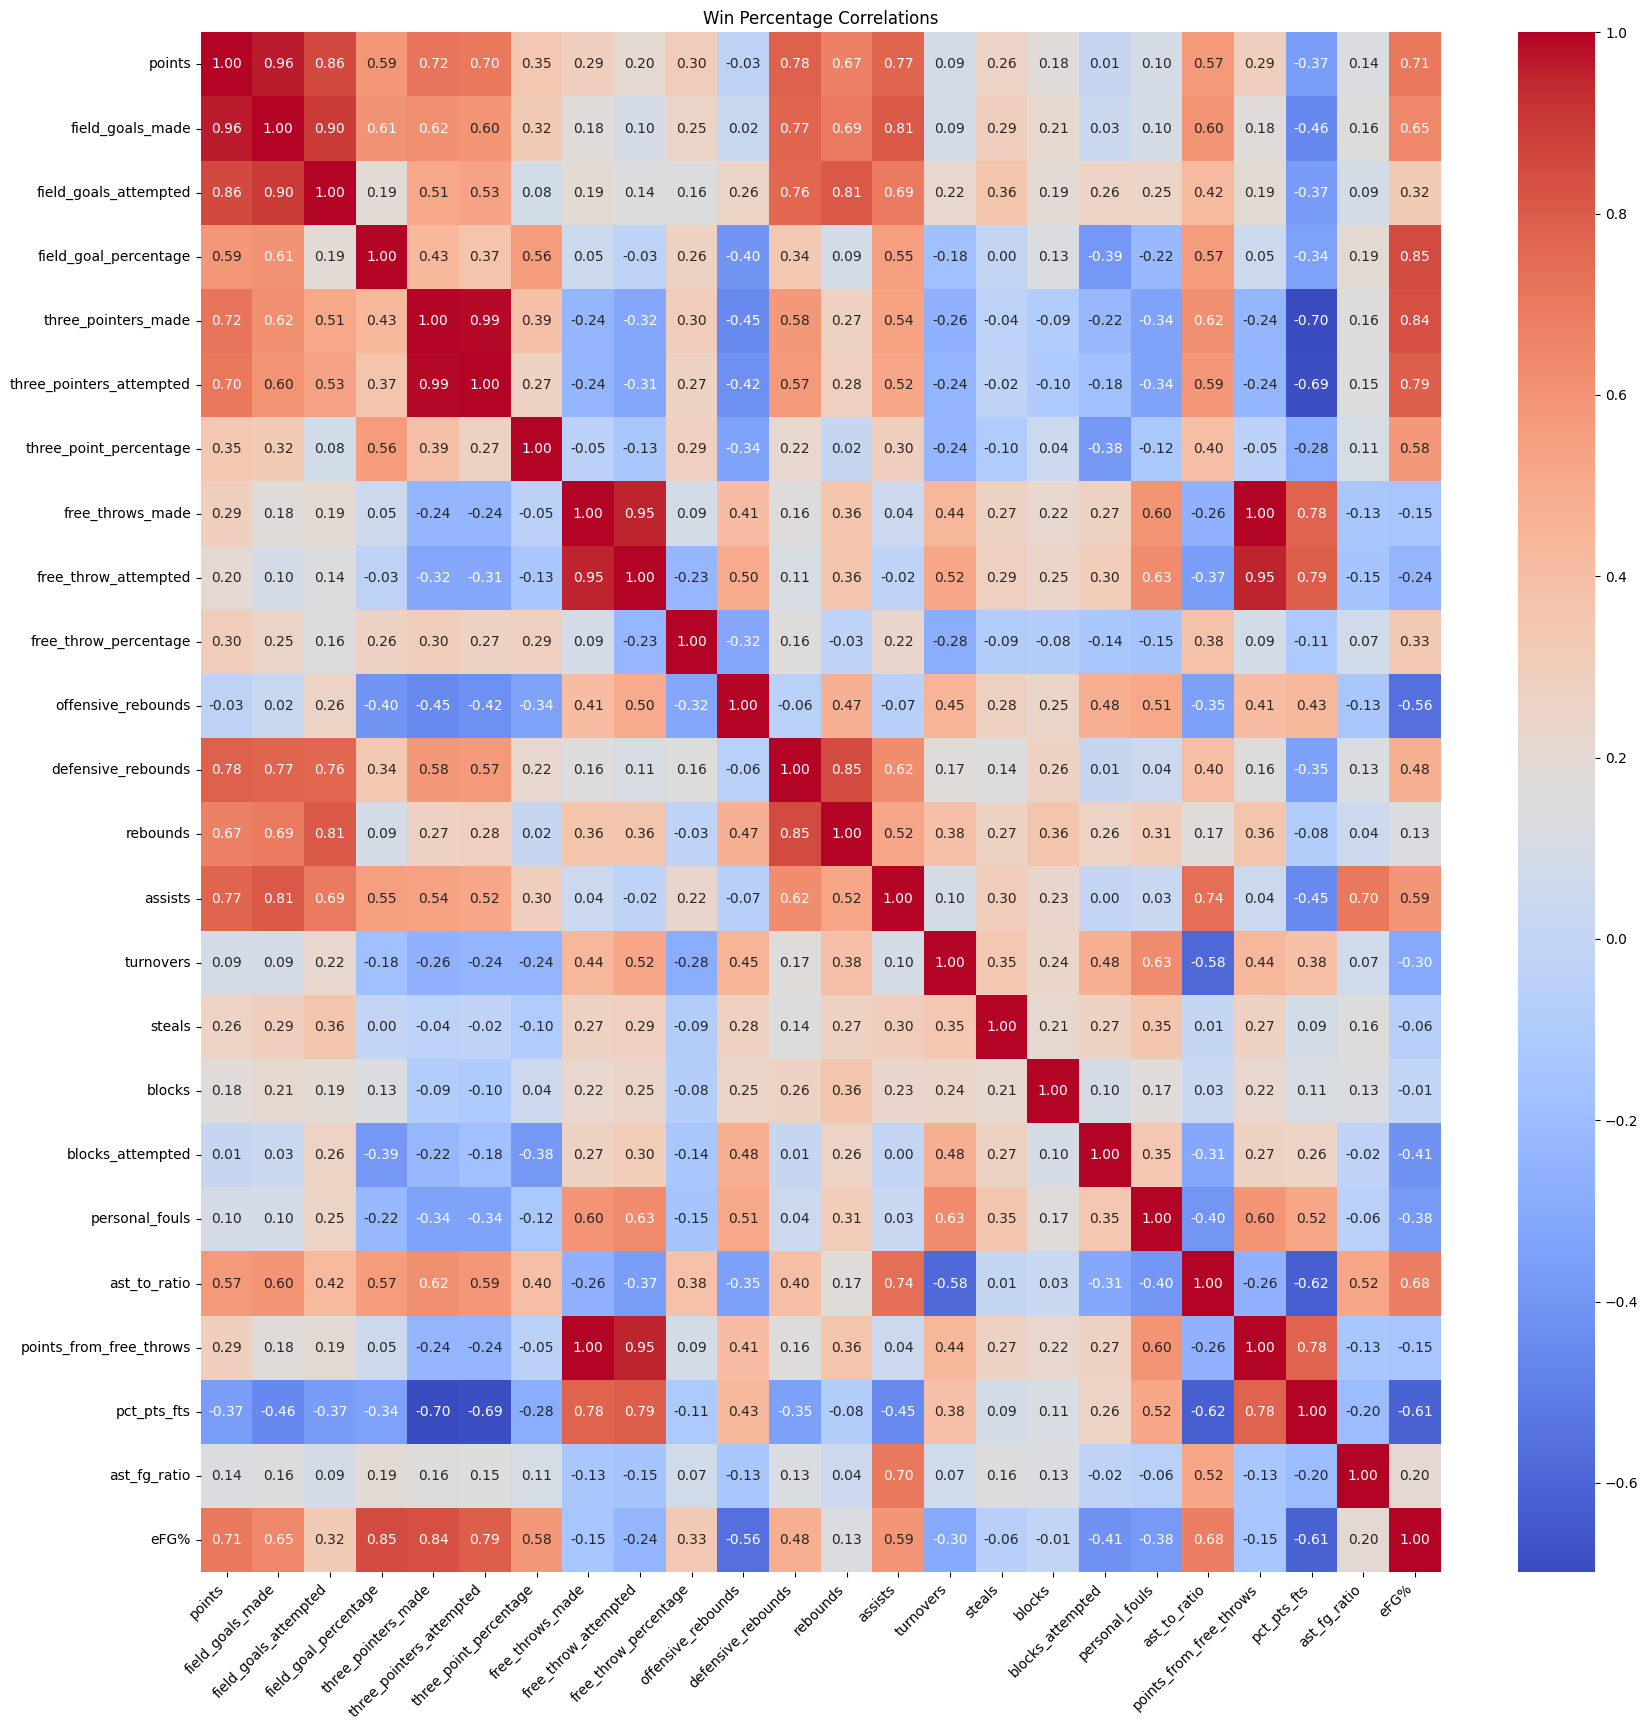

In [45]:
# Call the show_matrix function to display the correlation matrix
show_matrix(feature_matrix, 'Win Percentage')

In [46]:
# Display the strong correlations from the matrix of the entire dataset minus the target variable
print(feature_strong_correlations)

                  Feature1                  Feature2  Correlation
1                   points          field_goals_made     0.961507
2                   points     field_goals_attempted     0.857562
26        field_goals_made     field_goals_attempted     0.895340
37        field_goals_made                   assists     0.813782
60   field_goals_attempted                  rebounds     0.807645
95   field_goal_percentage                      eFG%     0.847405
101    three_pointers_made  three_pointers_attempted     0.991025
119    three_pointers_made                      eFG%     0.835662
176       free_throws_made      free_throw_attempted     0.949218
188       free_throws_made   points_from_free_throws     1.000000
212   free_throw_attempted   points_from_free_throws     0.949218
276     defensive_rebounds                  rebounds     0.852678


In [47]:
# Call the drop_redundant_feats function on the dataset
df_features = drop_redundant_feats(feature_strong_correlations, df_features)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   assists                   716 non-null    int64  
 6   turnovers                 716 non-null    int64  
 7   steals                    716 non-null    int64  
 8   blocks                    716 non-null    int64  
 9   blocks_attempted          716 non-null    int64  
 10  personal_fouls            716 non-null    int64  
 11  ast_to_ratio              716 non-null    float64
 12  points_from_free_throws   716 non-null    int64  
 13  pct_pts_fts               716 non-null    float64
 14  ast_fg_rat

In [48]:
# Generate the matrix for the reduced features with the gen_corr_matrix function
red_feat_matrix, red_feat_strong_correlations = gen_corr_matrix(df_features)
red_feat_strong_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [49]:
# Drop the assists, turnovers, and points_from_free_throws features, as these can be accounted for in other features
df_features = df_features.drop(['assists', 'turnovers', 'points_from_free_throws'], axis=1)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [50]:
# Create a copy of the dataset for later use
df_feats_master = df_features.copy()

In [51]:
# Define the target variable for the dataset
y = df_num['win_percentage']

# Train the model for the dataset
results_num, df_features = gen_lasso_model(df_features, y)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       0.499784
std        0.148919
min        0.106000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.890000
Name: win_percentage, dtype: float64
Training RMSE: 0.08982411888818949, Testing RMSE: 0.09174493633048802
Training R^2: 0.6420785766648467, Testing R^2: 0.5853796175431967
Non-zero Coefficients: 
eFG%                        0.068475
pct_pts_fts                 0.064467
rebounds                    0.043390
steals                      0.038492
three_point_percentage      0.038109
ast_to_ratio                0.031328
blocks                      0.011656
offensive_rebounds          0.001625
ast_fg_ratio               -0.002806
free_throw_percentage      -0.007664
personal_fouls             -0.040795
blocks_attempted           -0.048991
three_pointers_attempted   -0.053870
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.873914
1    

In [52]:
# Drop the three_point_percentage feature to reduce vif scores
df_features = df_features.drop(['three_point_percentage'], axis=1)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 67.2 KB


In [53]:
# retrain the model
results_num, df_features = gen_lasso_model(df_features, y)

Best Alpha: 0.0005
Y Measurables: 
count    716.000000
mean       0.499784
std        0.148919
min        0.106000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.890000
Name: win_percentage, dtype: float64
Training RMSE: 0.09406934554472911, Testing RMSE: 0.0949154163172767
Training R^2: 0.6074472651017013, Testing R^2: 0.5562279408501041
Non-zero Coefficients: 
eFG%                        0.099938
pct_pts_fts                 0.058258
rebounds                    0.045927
steals                      0.034902
ast_to_ratio                0.030301
blocks                      0.012247
free_throw_percentage      -0.001807
ast_fg_ratio               -0.002365
personal_fouls             -0.032596
blocks_attempted           -0.053545
three_pointers_attempted   -0.072189
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.200511
1      free_throw_percentage  1.328130
2                   rebounds  1.831217
3 

In [54]:
# With feature selection finalized, create a series of regression coefficients
num_coefficients = pd.Series(results_num['non_zero_coefficients'])

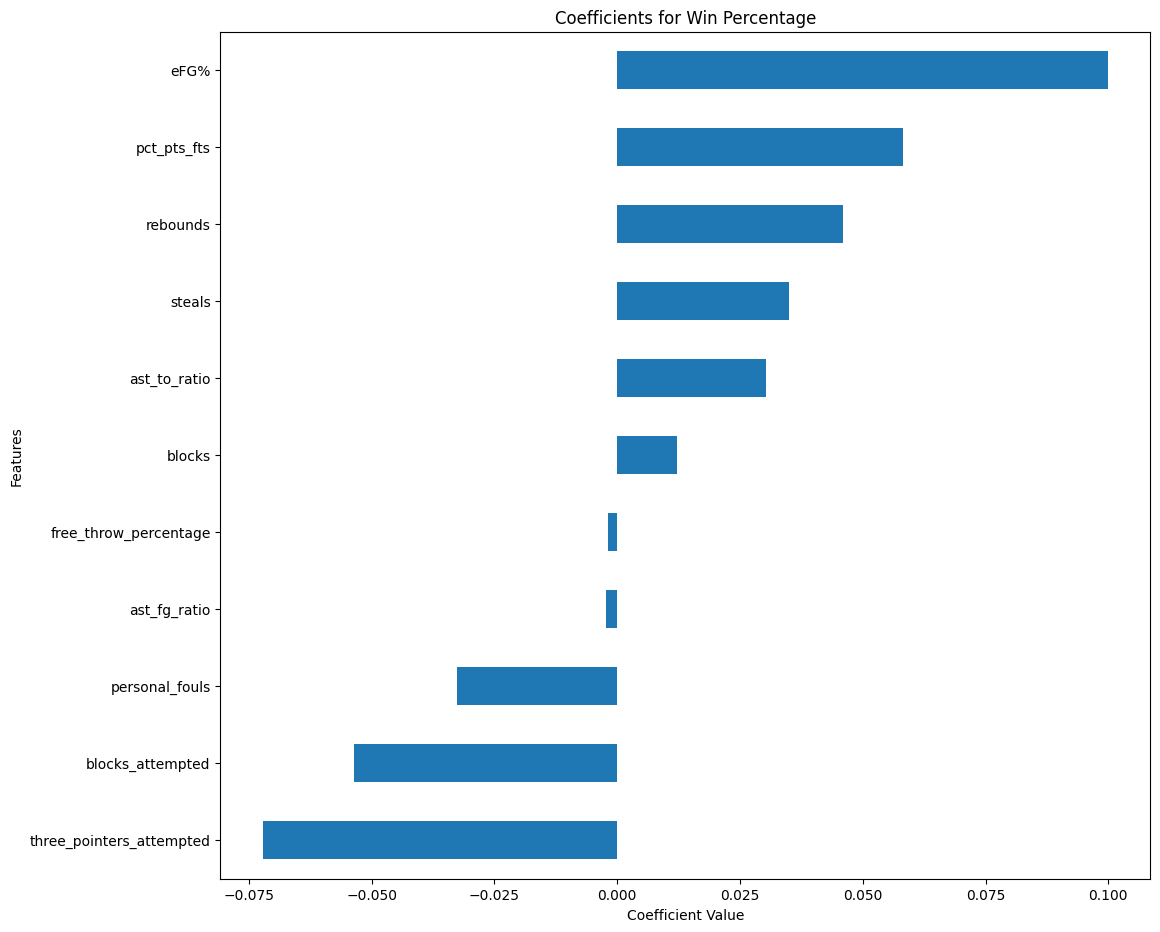

In [55]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(num_coefficients, 'Win Percentage')

In [56]:
# Generate bootstrap coefficients 
bootstrap_results_num = gen_bootstrap_coefficients(
    results_num['model'], results_num['X'], results_num['y'], results_num['feature_names']
)

Average Y: 0.49978351955307265
Average Training RMSE: 0.0929839247967667, Average Testing RMSE: 0.09489586142089804
Average Training R^2: 0.6082825094252319, Average Testing R^2: 0.5859578911395841
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
eFG%                      0.094221  0.007568  0.079592  0.107937
pct_pts_fts               0.053669  0.006192  0.042308  0.066144
rebounds                  0.048167  0.005317  0.037332  0.058644
steals                    0.032375  0.004408  0.023747  0.040868
ast_to_ratio              0.030447  0.006598  0.017866  0.043642
blocks                    0.009927  0.004429  0.001208  0.018775
free_throw_percentage    -0.000549  0.003654 -0.007686  0.007399
ast_fg_ratio             -0.001738  0.004522 -0.010746  0.006840
personal_fouls           -0.035293  0.005682 -0.047056 -0.024755
blocks_attempted         -0.052490  0.004566 -0.062246 -0.044158
three_pointers_attempted -0.069897  0.008396 -0.086471 -0.053191


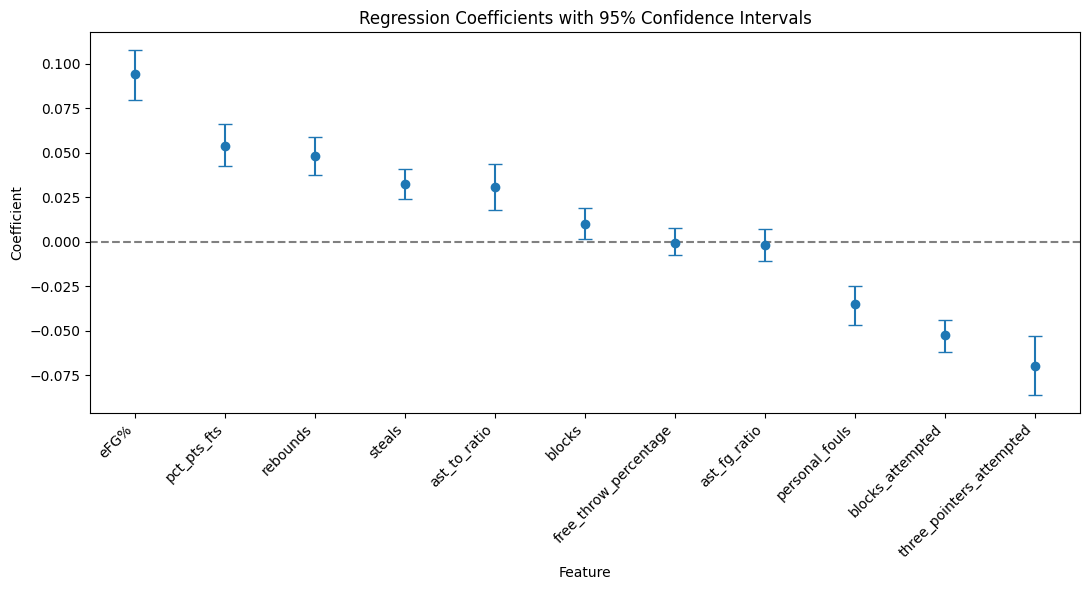

In [57]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_num)

In [58]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_num, df_features)

A 0.010 unit increase in eFG% results in an approximate 0.0335 (or 3.35 percentage points) change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate 0.0085 (or 0.85 percentage points) change in the target variable.
A 68.781 unit increase in rebounds results in an approximate 0.0143 (or 1.43 percentage points) change in the target variable.
A 12.188 unit increase in steals results in an approximate 0.0054 (or 0.54 percentage points) change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate 0.0043 (or 0.43 percentage points) change in the target variable.
A 7.869 unit increase in blocks results in an approximate 0.0012 (or 0.12 percentage points) change in the target variable.
A 33.376 unit increase in personal_fouls results in an approximate -0.0067 (or -0.67 percentage points) change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate -0.0070 (or -0.70 percentage points) cha

In [59]:
# Repeat the process above with each selected feature as the target variable, starting with eFG%

In [60]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [61]:
# Drop the target variable from the features
efg_feats_full = df_feats_master.drop(['eFG%'], axis=1)

efg_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 67.2 KB


In [62]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
efg_full_feature_matrix, efg_full_feat_str_correlations = gen_corr_matrix(efg_feats_full)

efg_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [63]:
# Define the target variable for the dataset
y_efg_full = df_feats_master['eFG%']

# Train the model for the dataset
results_efg_full, efg_feats_full = gen_lasso_model(efg_feats_full, y_efg_full)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       0.504032
std        0.028349
min        0.428408
25%        0.483103
50%        0.500796
75%        0.524801
max        0.578497
Name: eFG%, dtype: float64
Training RMSE: 0.011709976704986209, Testing RMSE: 0.011660509575745139
Training R^2: 0.8271816569365852, Testing R^2: 0.8349987695033454
Non-zero Coefficients: 
three_pointers_attempted    0.015830
three_point_percentage      0.007810
ast_to_ratio                0.006899
pct_pts_fts                 0.002105
blocks                      0.001468
steals                      0.000904
rebounds                    0.000169
personal_fouls             -0.000294
free_throw_percentage      -0.001121
ast_fg_ratio               -0.001834
blocks_attempted           -0.002094
offensive_rebounds         -0.004735
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.037678
1     three_point_percentage  1.448683
2      free

In [64]:
# With feature selection finalized, create a series of regression coefficients
efg_full_coefficients = pd.Series(results_efg_full['non_zero_coefficients'])

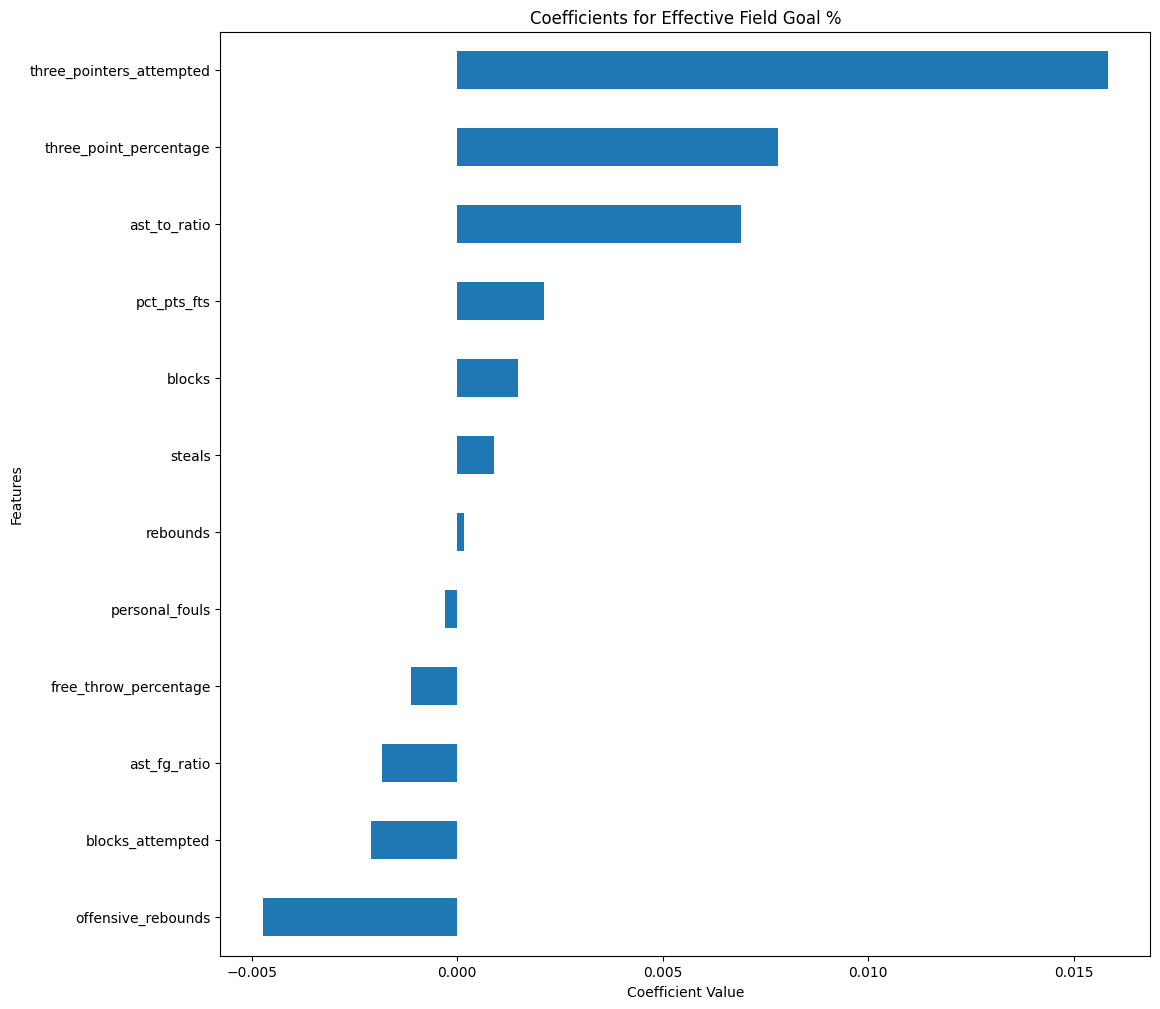

In [65]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(efg_full_coefficients, 'Effective Field Goal %')

In [66]:
# Generate bootstrap coefficients 
bootstrap_results_efg_full = gen_bootstrap_coefficients(
    results_efg_full['model'], results_efg_full['X'], results_efg_full['y'], results_efg_full['feature_names']
)

Average Y: 0.5040322200718343
Average Training RMSE: 0.011535314335909572, Average Testing RMSE: 0.011770133411271493
Average Training R^2: 0.8338909399362588, Average Testing R^2: 0.8236369757859803
Sorted Coefficients: 
                              Mean    StdDev      CI Lower  CI Upper
three_pointers_attempted  0.015613  0.000783  1.400369e-02  0.017044
three_point_percentage    0.007813  0.000614  6.626183e-03  0.009007
ast_to_ratio              0.006280  0.000949  4.492454e-03  0.008155
pct_pts_fts               0.002122  0.000807  4.952852e-04  0.003683
blocks                    0.001923  0.000554  7.849215e-04  0.003032
steals                    0.000882  0.000544 -3.858077e-07  0.001976
rebounds                  0.000561  0.000635 -4.600212e-04  0.001957
personal_fouls           -0.000635  0.000633 -1.917132e-03  0.000432
free_throw_percentage    -0.000847  0.000561 -1.981865e-03  0.000071
ast_fg_ratio             -0.001313  0.000646 -2.569826e-03 -0.000044
blocks_attempted   

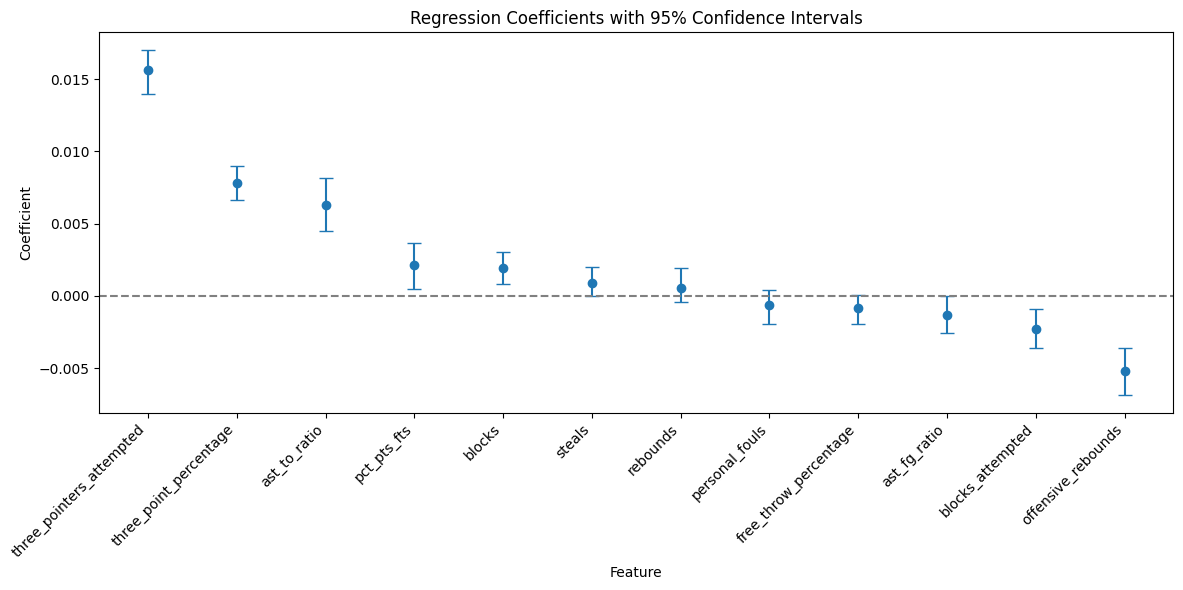

In [67]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_efg_full)

In [68]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_efg_full, efg_feats_full)

A 36.573 unit increase in three_pointers_attempted results in an approximate 0.0009 (or 0.09 percentage points) change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate 0.0029 (or 0.29 percentage points) change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate 0.0009 (or 0.09 percentage points) change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate 0.0003 (or 0.03 percentage points) change in the target variable.
A 7.869 unit increase in blocks results in an approximate 0.0002 (or 0.02 percentage points) change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -0.0004 (or -0.04 percentage points) change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate -0.0003 (or -0.03 percentage points) change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approxi

In [69]:
# Continue with secondary feature regression analysis using pct_pts_fts as the target variable

In [70]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [71]:
# Drop the target variable from the features
ppfs_feats_full = df_feats_master.drop(['pct_pts_fts'], axis=1)

ppfs_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 67.2 KB


In [72]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ppfs_full_feature_matrix, ppfs_full_feat_str_correlations = gen_corr_matrix(ppfs_feats_full)

ppfs_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [73]:
# Define the target variable for the dataset
y_ppfs_full = df_feats_master['pct_pts_fts']

# Train the model for the dataset
results_ppfs_full, ppfs_feats_full = gen_lasso_model(ppfs_feats_full, y_ppfs_full)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       0.177105
std        0.022458
min        0.124383
25%        0.159522
50%        0.175891
75%        0.192052
max        0.239480
Name: pct_pts_fts, dtype: float64
Training RMSE: 0.01324471004404291, Testing RMSE: 0.013692099663341617
Training R^2: 0.6451832997409412, Testing R^2: 0.6507793632784002
Non-zero Coefficients: 
personal_fouls              0.004828
free_throw_percentage       0.004704
eFG%                        0.003209
offensive_rebounds          0.002916
blocks                      0.001201
ast_fg_ratio                0.001167
blocks_attempted           -0.000073
steals                     -0.000187
rebounds                   -0.000971
three_point_percentage     -0.001380
ast_to_ratio               -0.008261
three_pointers_attempted   -0.010913
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.087472
1     three_point_percentage  1.872135
2    

In [74]:
# Drop the three_point_percentage feature to reduce vif scores
ppfs_feats_full = ppfs_feats_full.drop(['three_point_percentage'], axis=1)

ppfs_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   ast_fg_ratio              716 non-null    float64
 10  eFG%                      716 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 61.7 KB


In [75]:
# Retrain the model
results_ppfs_full, ppfs_feats_full = gen_lasso_model(ppfs_feats_full, y_ppfs_full)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       0.177105
std        0.022458
min        0.124383
25%        0.159522
50%        0.175891
75%        0.192052
max        0.239480
Name: pct_pts_fts, dtype: float64
Training RMSE: 0.013309382594280475, Testing RMSE: 0.013901328027624832
Training R^2: 0.6417097734094804, Testing R^2: 0.6400249676576061
Non-zero Coefficients: 
personal_fouls              0.004608
free_throw_percentage       0.004571
offensive_rebounds          0.003036
eFG%                        0.001996
ast_fg_ratio                0.001213
blocks                      0.001197
steals                     -0.000071
rebounds                   -0.001097
ast_to_ratio               -0.008370
three_pointers_attempted   -0.010227
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.482958
1      free_throw_percentage  1.276943
2         offensive_rebounds  2.985240
3                   rebounds  2.536051


In [76]:
# With feature selection finalized, create a series of regression coefficients
ppfs_full_coefficients = pd.Series(results_ppfs_full['non_zero_coefficients'])

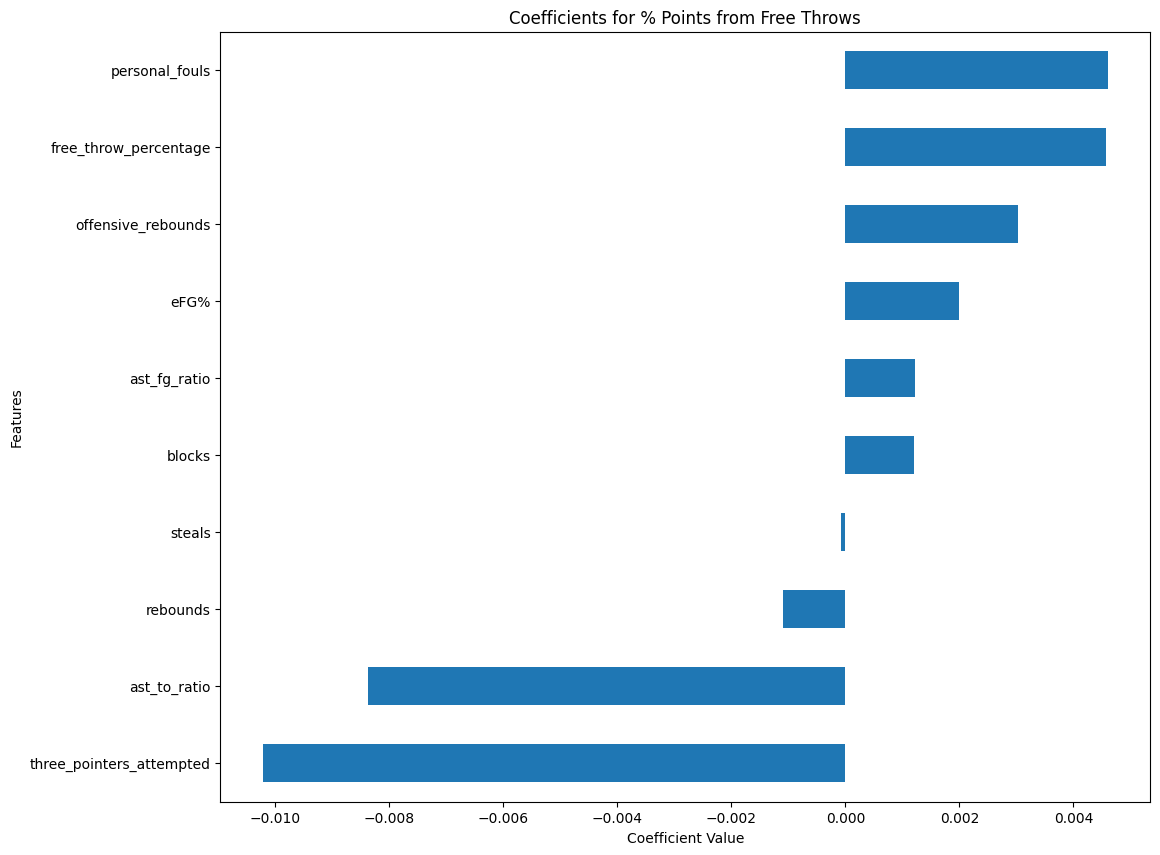

In [77]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ppfs_full_coefficients, '% Points from Free Throws')

In [78]:
# Generate bootstrap coefficients 
bootstrap_results_ppfs_full = gen_bootstrap_coefficients(
    results_ppfs_full['model'], results_ppfs_full['X'], results_ppfs_full['y'], results_ppfs_full['feature_names']
)

Average Y: 0.1771050755721094
Average Training RMSE: 0.013309538422134648, Average Testing RMSE: 0.01350687900336631
Average Training R^2: 0.6473683656407511, Average Testing R^2: 0.6316490775403502
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
personal_fouls            0.005077  0.000708  0.003745  0.006510
free_throw_percentage     0.004160  0.000651  0.002943  0.005390
offensive_rebounds        0.002248  0.000907  0.000498  0.004101
eFG%                      0.001588  0.001098  0.000000  0.004015
ast_fg_ratio              0.001048  0.000688 -0.000057  0.002384
blocks                    0.000605  0.000601 -0.000498  0.001816
steals                   -0.000204  0.000565 -0.001373  0.000883
rebounds                 -0.000483  0.000746 -0.002104  0.000818
ast_to_ratio             -0.008167  0.000973 -0.010048 -0.006354
three_pointers_attempted -0.010316  0.000968 -0.012231 -0.008563


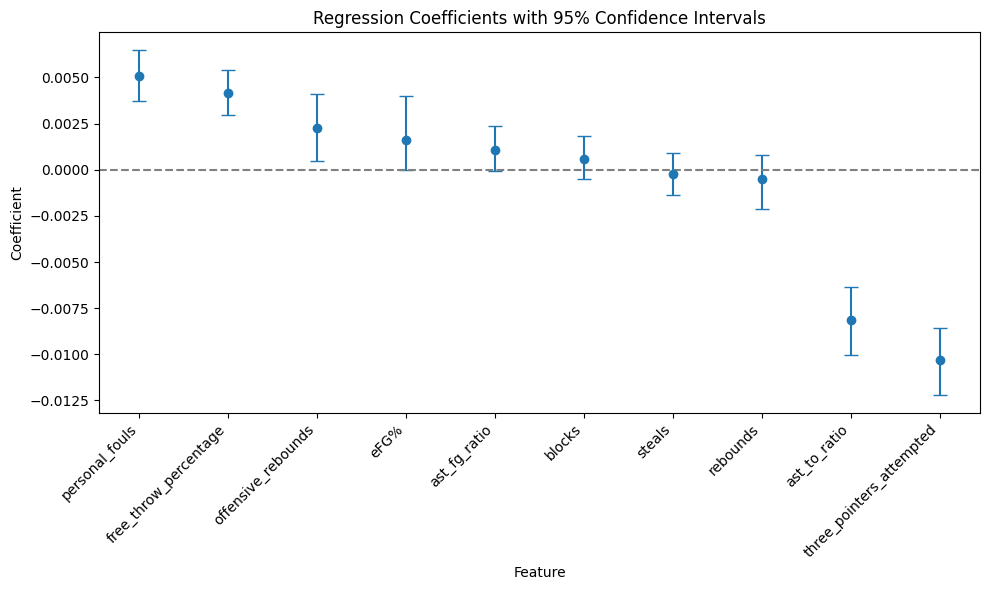

In [79]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ppfs_full)

In [80]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ppfs_full, ppfs_feats_full)

A 33.376 unit increase in personal_fouls results in an approximate 0.0010 (or 0.10 percentage points) change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate 0.0021 (or 0.21 percentage points) change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approximate 0.0003 (or 0.03 percentage points) change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate -0.0012 (or -0.12 percentage points) change in the target variable.
A 36.573 unit increase in three_pointers_attempted results in an approximate -0.0006 (or -0.06 percentage points) change in the target variable.


In [81]:
# Continue with secondary feature regression analysis using rebounds as the target variable

In [82]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [83]:
# Drop the target variable from the features
reb_feats_full = df_feats_master.drop(['rebounds'], axis=1)

reb_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [84]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
reb_full_feature_matrix, reb_full_feat_str_correlations = gen_corr_matrix(reb_feats_full)

reb_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [85]:
# Drop the offensive_rebounds feature
reb_feats_full = reb_feats_full.drop(['offensive_rebounds'], axis=1)

reb_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   steals                    716 non-null    int64  
 4   blocks                    716 non-null    int64  
 5   blocks_attempted          716 non-null    int64  
 6   personal_fouls            716 non-null    int64  
 7   ast_to_ratio              716 non-null    float64
 8   pct_pts_fts               716 non-null    float64
 9   ast_fg_ratio              716 non-null    float64
 10  eFG%                      716 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 61.7 KB


In [86]:
# Define the target variable for the dataset
y_reb_full = df_feats_master['rebounds']

# Train the model for the dataset
results_reb_full, reb_feats_full = gen_lasso_model(reb_feats_full, y_reb_full)

Best Alpha: 0.1
Y Measurables: 
count     716.000000
mean     3439.062849
std       232.258935
min      2560.000000
25%      3325.000000
50%      3459.500000
75%      3585.250000
max      4078.000000
Name: rebounds, dtype: float64
Training RMSE: 170.30731484208354, Testing RMSE: 178.84844942759236
Training R^2: 0.4370035434323637, Testing R^2: 0.49383327642664276
Non-zero Coefficients: 
three_pointers_attempted    107.078004
ast_to_ratio                 81.510249
personal_fouls               77.959287
blocks                       68.933778
blocks_attempted             49.158303
steals                       15.800755
three_point_percentage       15.541711
pct_pts_fts                   5.561741
free_throw_percentage       -30.152657
ast_fg_ratio                -41.784422
eFG%                        -49.670232
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.256437
1     three_point_percentage  1.902062
2      free_throw_pe

In [87]:
# Drop the three_point_percentage features to reduce vif scores
reb_feats_full = reb_feats_full.drop(['three_point_percentage'], axis=1)

reb_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   steals                    716 non-null    int64  
 3   blocks                    716 non-null    int64  
 4   blocks_attempted          716 non-null    int64  
 5   personal_fouls            716 non-null    int64  
 6   ast_to_ratio              716 non-null    float64
 7   pct_pts_fts               716 non-null    float64
 8   ast_fg_ratio              716 non-null    float64
 9   eFG%                      716 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 56.1 KB


In [88]:
# Retrain the model
results_reb_full, reb_feats_full = gen_lasso_model(reb_feats_full, y_reb_full)

Best Alpha: 0.1
Y Measurables: 
count     716.000000
mean     3439.062849
std       232.258935
min      2560.000000
25%      3325.000000
50%      3459.500000
75%      3585.250000
max      4078.000000
Name: rebounds, dtype: float64
Training RMSE: 170.71051339809657, Testing RMSE: 177.22740063090927
Training R^2: 0.4343346261711646, Testing R^2: 0.5029672939343066
Non-zero Coefficients: 
three_pointers_attempted    99.419194
ast_to_ratio                81.889011
personal_fouls              81.173922
blocks                      69.452952
blocks_attempted            47.384027
steals                      14.611603
pct_pts_fts                  3.492073
free_throw_percentage      -28.130419
eFG%                       -36.075842
ast_fg_ratio               -42.117861
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.742639
1      free_throw_percentage  1.307804
2                     steals  1.277566
3                     blocks  1

In [89]:
# With feature selection finalized, create a series of regression coefficients
reb_full_coefficients = pd.Series(results_reb_full['non_zero_coefficients'])

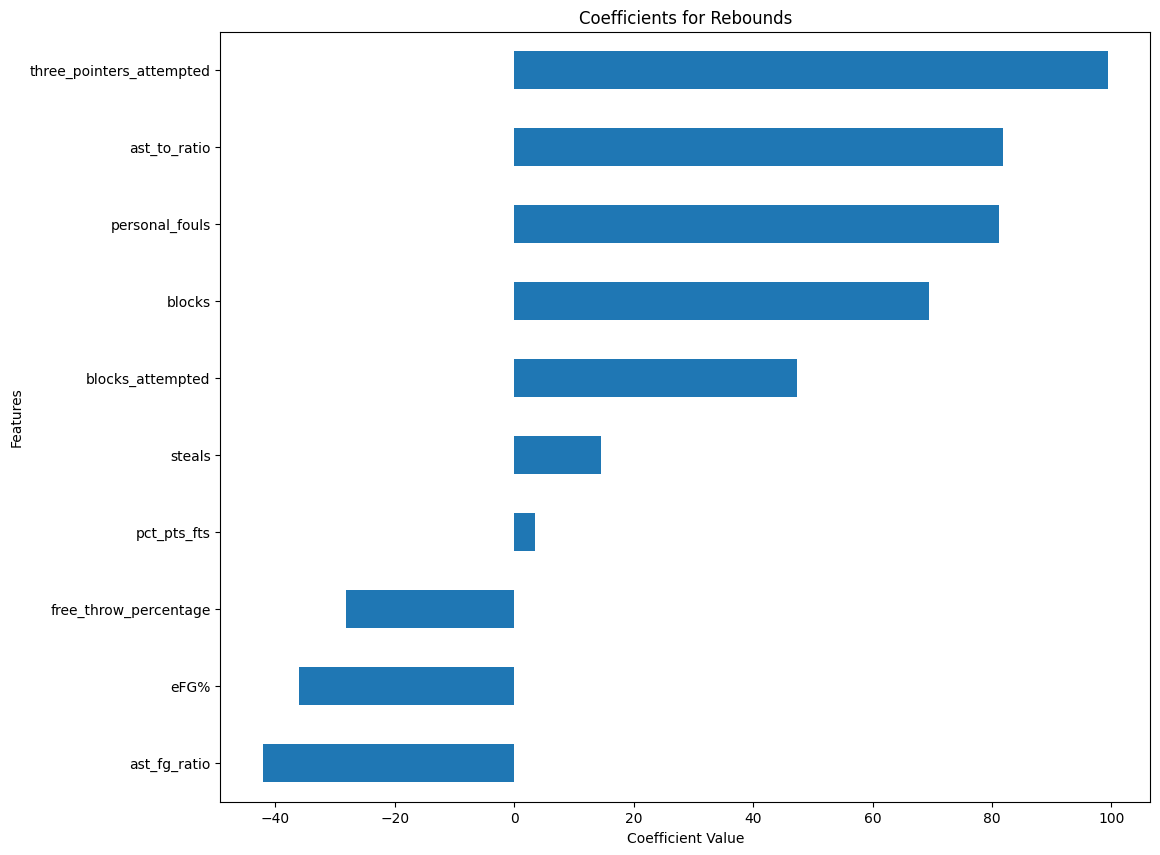

In [90]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(reb_full_coefficients, 'Rebounds')

In [91]:
# Generate bootstrap coefficients 
bootstrap_results_reb_full = gen_bootstrap_coefficients(
    results_reb_full['model'], results_reb_full['X'], results_reb_full['y'], results_reb_full['feature_names']
)

Average Y: 3439.0628491620114
Average Training RMSE: 169.5921371571982, Average Testing RMSE: 173.17242564857145
Average Training R^2: 0.460731407475546, Average Testing R^2: 0.4276206117346584
Sorted Coefficients: 
                                Mean     StdDev   CI Lower    CI Upper
three_pointers_attempted  115.152387  14.944500  85.373985  143.065216
personal_fouls             83.268133  10.531300  61.580315  104.251698
ast_to_ratio               82.028680  13.468339  55.375279  108.793253
blocks                     74.995150   7.874062  59.457244   90.204572
blocks_attempted           43.287712   8.505611  27.299215   59.444982
pct_pts_fts                 9.832306  11.787821 -13.628518   31.595169
steals                      7.868711   8.059397  -8.244526   23.507467
free_throw_percentage     -24.089415   8.572063 -41.419967   -6.897822
ast_fg_ratio              -42.083277   9.017079 -59.024553  -24.195627
eFG%                      -43.448277  13.967154 -70.468638  -16.250326


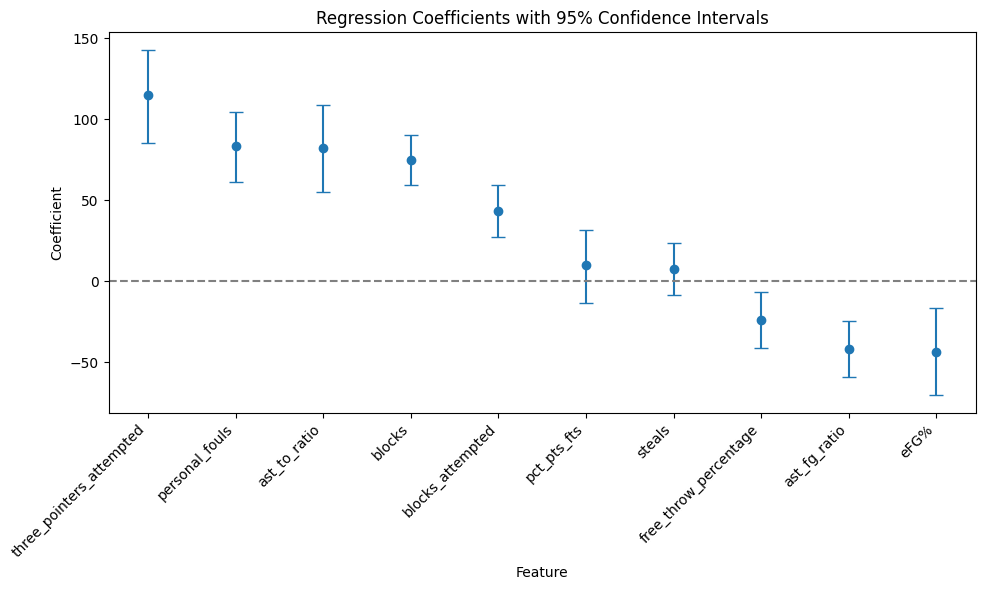

In [92]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_reb_full)

In [93]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_reb_full, reb_feats_full, False)

A 36.573 unit increase in three_pointers_attempted results in an approximate 6.404 change in the target variable.
A 33.376 unit increase in personal_fouls results in an approximate 15.831 change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate 11.570 change in the target variable.
A 7.869 unit increase in blocks results in an approximate 8.813 change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate 5.773 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate -12.234 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -12.419 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate -15.461 change in the target variable.


In [94]:
# Continue with secondary feature regression analysis using steals as the target variable

In [95]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [96]:
# Drop the target variable from the features
steals_feats_full = df_feats_master.drop(['steals'], axis=1)

steals_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [97]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
steals_full_feature_matrix, steals_full_feat_str_correlations = gen_corr_matrix(steals_feats_full)

steals_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [98]:
# Define the target variable for the dataset
y_steals_full = df_feats_master['steals']

# Train the model for the dataset
results_steals_full, steals_feats_full = gen_lasso_model(steals_feats_full, y_steals_full)

Best Alpha: 0.1
Y Measurables: 
count    716.000000
mean     609.410615
std       73.742012
min      390.000000
25%      559.750000
50%      605.000000
75%      657.000000
max      844.000000
Name: steals, dtype: float64
Training RMSE: 63.23982644988141, Testing RMSE: 71.46468783445943
Training R^2: 0.19821343208812436, Testing R^2: 0.2888940464044799
Non-zero Coefficients: 
personal_fouls            17.368891
eFG%                      11.374485
offensive_rebounds        11.190752
blocks_attempted           9.104977
ast_fg_ratio               8.843955
blocks                     6.018112
ast_to_ratio               4.536129
rebounds                   1.681538
free_throw_percentage     -2.294334
pct_pts_fts               -2.451910
three_point_percentage    -7.512495
dtype: float64
Variance Inflation Factors: 
                   feature       vif
0   three_point_percentage  1.673752
1    free_throw_percentage  1.408130
2       offensive_rebounds  3.040403
3                 rebounds  2.2330

In [99]:
# With feature selection finalized, create a series of regression coefficients
steals_full_coefficients = pd.Series(results_steals_full['non_zero_coefficients'])

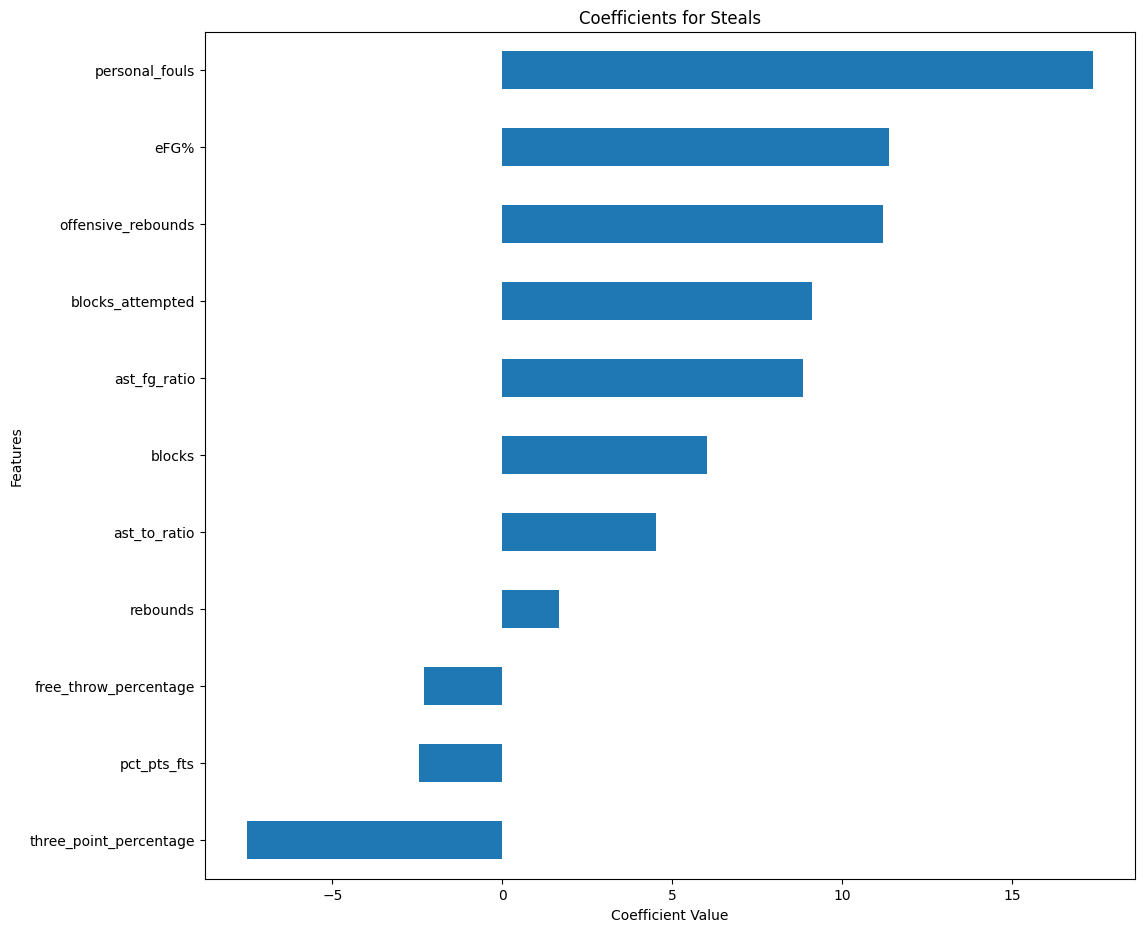

In [100]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(steals_full_coefficients, 'Steals')

In [101]:
# Generate bootstrap coefficients 
bootstrap_results_steals_full = gen_bootstrap_coefficients(
    results_steals_full['model'], results_steals_full['X'], results_steals_full['y'], results_steals_full['feature_names']
)

Average Y: 609.4106145251396
Average Training RMSE: 63.935328006859244, Average Testing RMSE: 65.24223830311008
Average Training R^2: 0.245028633147361, Average Testing R^2: 0.20262329008466226
Sorted Coefficients: 
                             Mean    StdDev   CI Lower   CI Upper
personal_fouls          24.274065  3.786227  16.546161  31.220662
blocks_attempted        10.823301  3.330804   4.512176  17.076316
eFG%                    10.441884  5.258164   0.921251  20.983029
offensive_rebounds       8.454318  4.768555  -0.197560  18.093805
ast_fg_ratio             8.144935  3.543996   1.548655  15.343234
blocks                   7.735168  3.108221   1.710759  13.404898
ast_to_ratio             7.205604  5.077308  -2.109896  17.079545
rebounds                -0.502010  3.799328  -8.697537   6.803827
free_throw_percentage   -2.992599  3.151928  -9.251645   2.863944
pct_pts_fts             -3.111991  4.077897 -11.306068   4.725106
three_point_percentage  -7.400549  3.592682 -14.177351  -0

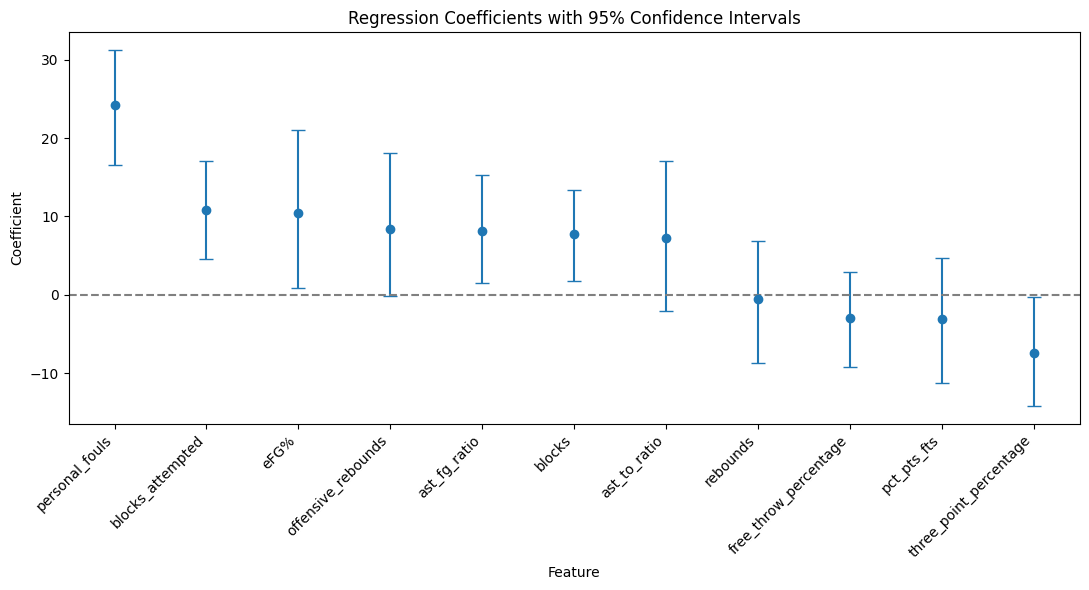

In [102]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_steals_full)

In [103]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_steals_full, steals_feats_full, False)

A 33.376 unit increase in personal_fouls results in an approximate 4.615 change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate 1.443 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate 3.716 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 2.404 change in the target variable.
A 7.869 unit increase in blocks results in an approximate 0.909 change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate -2.783 change in the target variable.


In [104]:
# Continue with secondary feature regression analysis using ast_to_ratio as the target variable

In [105]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [106]:
# Drop the target variable from the features
atr_feats_full = df_feats_master.drop(['ast_to_ratio'], axis=1)

atr_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 67.2 KB


In [107]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
atr_full_feature_matrix, atr_full_feat_str_correlations = gen_corr_matrix(atr_feats_full)

atr_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [108]:
# Define the target variable for the dataset
y_atr_full = df_feats_master['ast_to_ratio']

# Train the model for the dataset
results_atr_full, atr_feats_full = gen_lasso_model(atr_feats_full, y_atr_full)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       1.581596
std        0.224416
min        1.013112
25%        1.425834
50%        1.564107
75%        1.728375
max        2.381492
Name: ast_to_ratio, dtype: float64
Training RMSE: 0.114786368455083, Testing RMSE: 0.11889834649780459
Training R^2: 0.7387798042236167, Testing R^2: 0.7125077397230755
Non-zero Coefficients: 
eFG%                        0.088372
ast_fg_ratio                0.084981
free_throw_percentage       0.052556
offensive_rebounds          0.040488
rebounds                    0.019558
steals                      0.004848
three_point_percentage      0.001238
three_pointers_attempted   -0.015204
blocks_attempted           -0.025036
personal_fouls             -0.037587
pct_pts_fts                -0.066288
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.606897
1     three_point_percentage  1.903754
2      free_throw_percentage  1.233905
3    

In [109]:
# Drop the three_point_percentage features to reduce vif scores
atr_feats_full = atr_feats_full.drop(['three_point_percentage'], axis=1)

atr_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks_attempted          716 non-null    int64  
 6   personal_fouls            716 non-null    int64  
 7   pct_pts_fts               716 non-null    float64
 8   ast_fg_ratio              716 non-null    float64
 9   eFG%                      716 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 56.1 KB


In [110]:
# Retrain the model
results_atr_full, atr_feats_full = gen_lasso_model(atr_feats_full, y_atr_full)

Best Alpha: 0.0001
Y Measurables: 
count    716.000000
mean       1.581596
std        0.224416
min        1.013112
25%        1.425834
50%        1.564107
75%        1.728375
max        2.381492
Name: ast_to_ratio, dtype: float64
Training RMSE: 0.11478934269780089, Testing RMSE: 0.11895223209073469
Training R^2: 0.738766267035515, Testing R^2: 0.7122470935183536
Non-zero Coefficients: 
eFG%                        0.089454
ast_fg_ratio                0.084969
free_throw_percentage       0.052720
offensive_rebounds          0.040432
rebounds                    0.019677
steals                      0.004754
three_pointers_attempted   -0.015864
blocks_attempted           -0.025188
personal_fouls             -0.037359
pct_pts_fts                -0.066445
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.048117
1      free_throw_percentage  1.200506
2         offensive_rebounds  3.032272
3                   rebounds  2.251434
4 

In [111]:
# With feature selection finalized, create a series of regression coefficients
atr_full_coefficients = pd.Series(results_atr_full['non_zero_coefficients'])

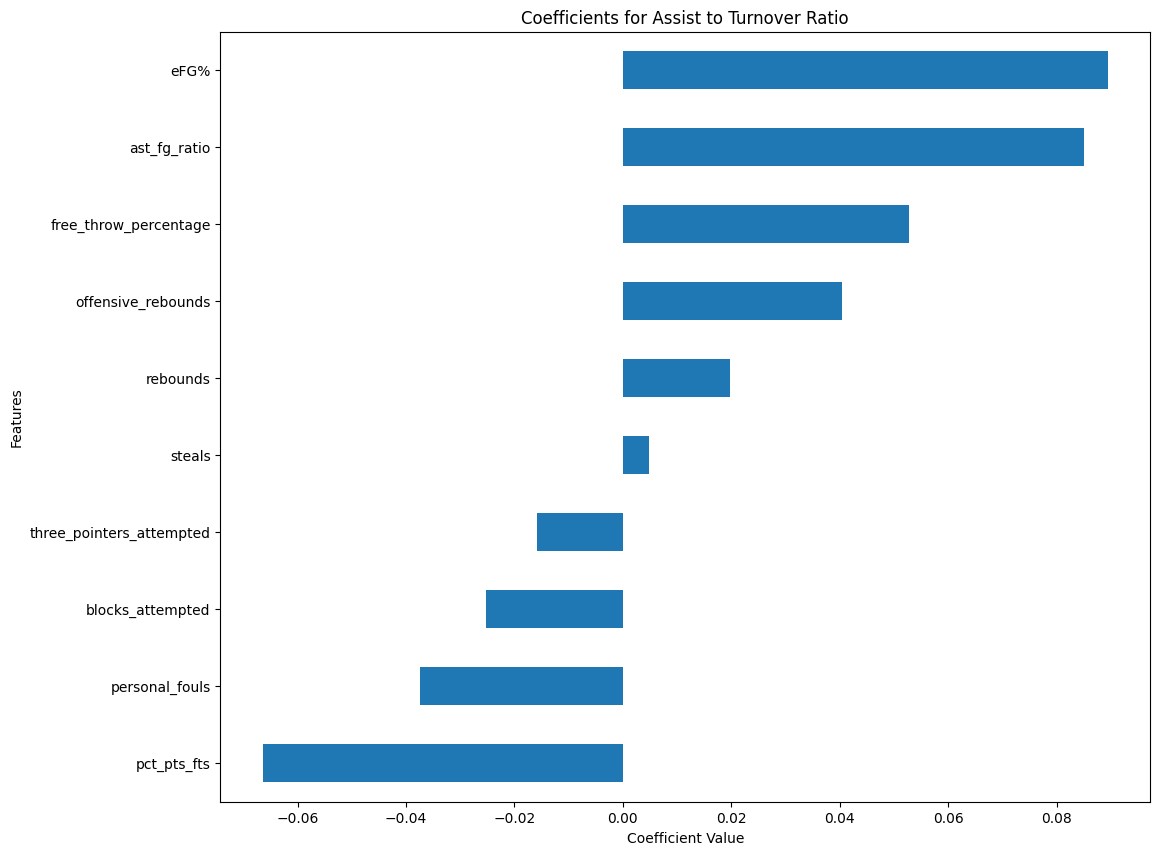

In [112]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(atr_full_coefficients, 'Assist to Turnover Ratio')

In [113]:
# Generate bootstrap coefficients 
bootstrap_results_atr_full = gen_bootstrap_coefficients(
    results_atr_full['model'], results_atr_full['X'], results_atr_full['y'], results_atr_full['feature_names']
)

Average Y: 1.5815964041291155
Average Training RMSE: 0.11404730586328093, Average Testing RMSE: 0.11603382519327801
Average Training R^2: 0.7404781546765365, Average Testing R^2: 0.7250788484022439
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
eFG%                      0.084474  0.009823  0.065968  0.104780
ast_fg_ratio              0.084443  0.004885  0.075051  0.093835
free_throw_percentage     0.050760  0.005650  0.039863  0.062546
offensive_rebounds        0.037663  0.009372  0.020484  0.056730
rebounds                  0.018489  0.007528  0.003516  0.033097
steals                    0.006925  0.005512 -0.003709  0.017785
three_pointers_attempted -0.010711  0.009357 -0.028882  0.007202
blocks_attempted         -0.024452  0.006674 -0.037229 -0.011475
personal_fouls           -0.033260  0.006853 -0.047134 -0.020057
pct_pts_fts              -0.064497  0.007511 -0.078984 -0.049648


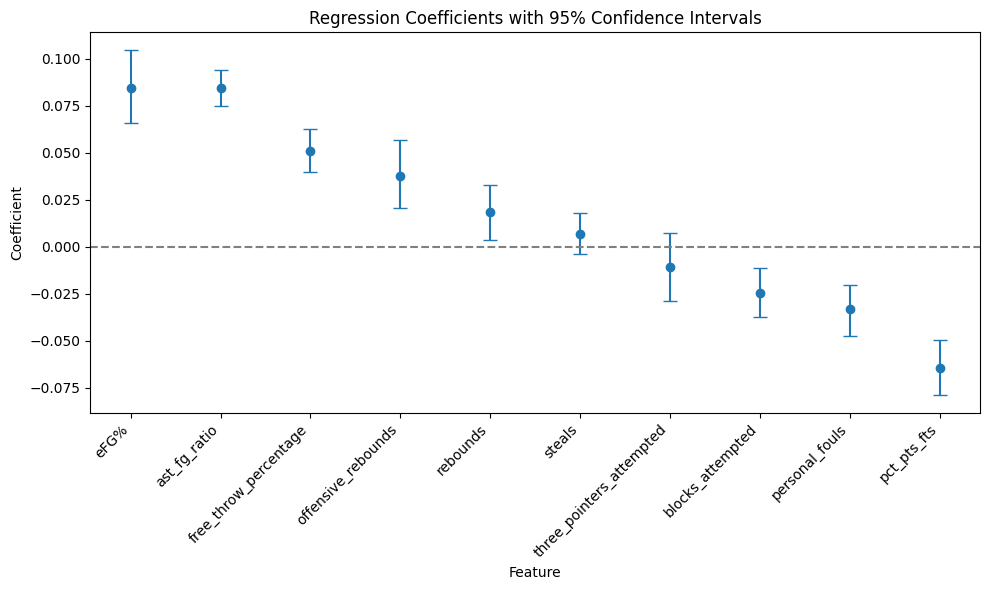

In [114]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_atr_full)

In [115]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_atr_full, atr_feats_full, False)

A 0.010 unit increase in eFG% results in an approximate 0.030 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 0.025 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate 0.026 change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approximate 0.005 change in the target variable.
A 68.781 unit increase in rebounds results in an approximate 0.005 change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate -0.003 change in the target variable.
A 33.376 unit increase in personal_fouls results in an approximate -0.006 change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate -0.010 change in the target variable.


In [116]:
# Continue with secondary feature regression analysis using blocks as the target variable

In [117]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [118]:
# Drop the target variable from the features
blocks_feats_full = df_feats_master.drop(['blocks'], axis=1)

blocks_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [119]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
blocks_full_feature_matrix, blocks_full_feat_str_correlations = gen_corr_matrix(blocks_feats_full)

blocks_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [120]:
# Define the target variable for the dataset
y_blocks_full = df_feats_master['blocks']

# Train the model for the dataset
results_blocks_full, blocks_feats_full = gen_lasso_model(blocks_feats_full, y_blocks_full)

Best Alpha: 0.1
Y Measurables: 
count    716.000000
mean     393.428771
std       67.002488
min      195.000000
25%      345.000000
50%      388.000000
75%      439.250000
max      624.000000
Name: blocks, dtype: float64
Training RMSE: 58.29588938015675, Testing RMSE: 59.57049784355488
Training R^2: 0.22530995204409787, Testing R^2: 0.2702887813580348
Non-zero Coefficients: 
rebounds                    28.644515
eFG%                        15.176036
pct_pts_fts                  8.269760
ast_fg_ratio                 7.213422
steals                       5.527881
blocks_attempted             1.874080
three_point_percentage       1.135603
offensive_rebounds          -1.864937
personal_fouls              -4.280075
free_throw_percentage       -5.325048
three_pointers_attempted   -22.889176
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.606897
1     three_point_percentage  1.903754
2      free_throw_percentage  1.233905
3   

In [121]:
# Drop the three_point_percentage feature to reduce vif scores
blocks_feats_full = blocks_feats_full.drop(['three_point_percentage'], axis=1)

blocks_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks_attempted          716 non-null    int64  
 6   personal_fouls            716 non-null    int64  
 7   pct_pts_fts               716 non-null    float64
 8   ast_fg_ratio              716 non-null    float64
 9   eFG%                      716 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 56.1 KB


In [122]:
# Retrain the model
results_blocks_full, blocks_feats_full = gen_lasso_model(blocks_feats_full, y_blocks_full)

Best Alpha: 0.1
Y Measurables: 
count    716.000000
mean     393.428771
std       67.002488
min      195.000000
25%      345.000000
50%      388.000000
75%      439.250000
max      624.000000
Name: blocks, dtype: float64
Training RMSE: 58.301985552918644, Testing RMSE: 59.52634922065427
Training R^2: 0.22514792033483366, Testing R^2: 0.2713699812401522
Non-zero Coefficients: 
rebounds                    28.753840
eFG%                        16.173394
pct_pts_fts                  8.123840
ast_fg_ratio                 7.202148
steals                       5.441130
blocks_attempted             1.736532
offensive_rebounds          -1.917068
personal_fouls              -4.070005
free_throw_percentage       -5.175057
three_pointers_attempted   -23.501268
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.048117
1      free_throw_percentage  1.200506
2         offensive_rebounds  3.032272
3                   rebounds  2.251434
4 

In [123]:
# With feature selection finalized, create a series of regression coefficients
blocks_full_coefficients = pd.Series(results_blocks_full['non_zero_coefficients'])

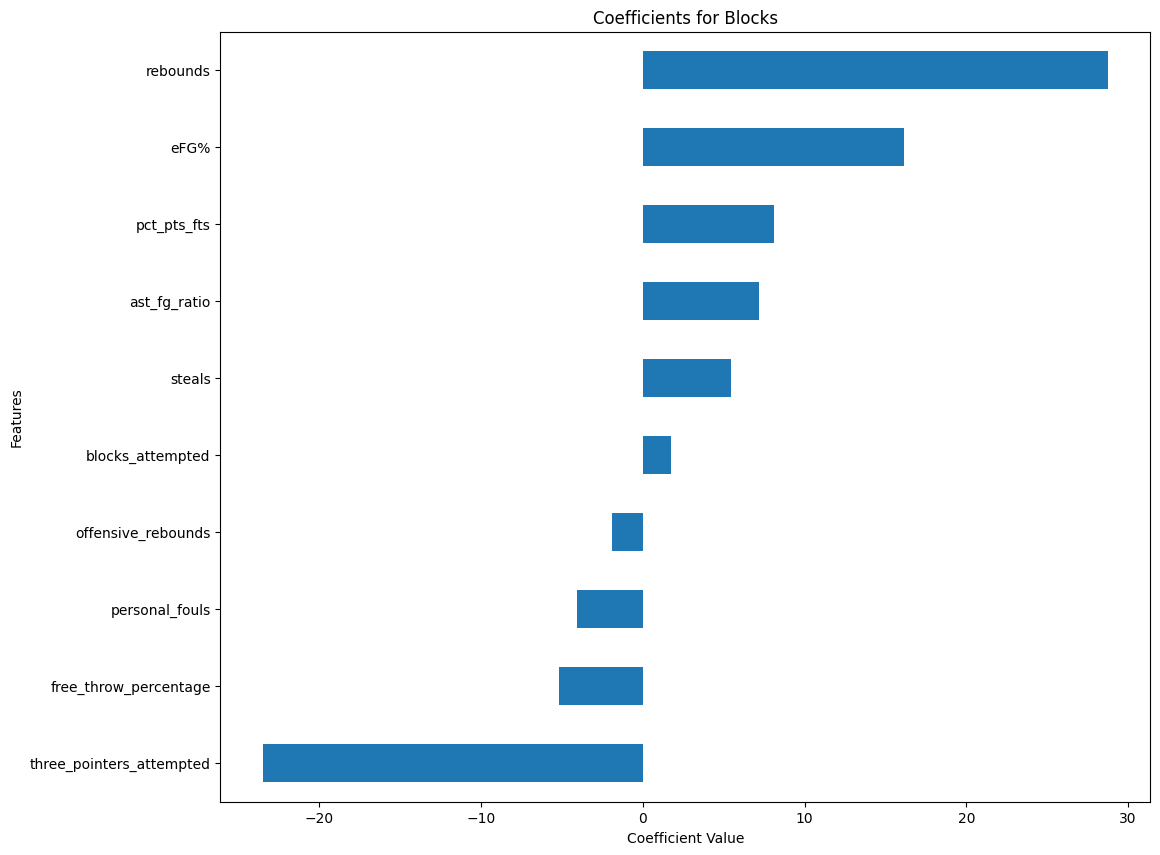

In [124]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(blocks_full_coefficients, 'Blocks')

In [125]:
# Generate bootstrap coefficients 
bootstrap_results_blocks_full = gen_bootstrap_coefficients(
    results_blocks_full['model'], results_blocks_full['X'], results_blocks_full['y'], results_blocks_full['feature_names']
)

Average Y: 393.4287709497207
Average Training RMSE: 57.864883115562975, Average Testing RMSE: 58.846761596073236
Average Training R^2: 0.2532826261931821, Average Testing R^2: 0.2168688031622502
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
rebounds                  29.895218  3.402298  23.067258  36.384338
eFG%                      19.506355  4.612726  10.577316  29.077275
ast_fg_ratio               7.731173  2.870851   1.825767  13.158108
steals                     6.629099  2.858487   0.845683  12.424027
pct_pts_fts                4.931921  3.999165  -3.033844  13.082588
blocks_attempted           0.106469  2.945973  -5.634994   5.997550
offensive_rebounds        -0.706052  3.604974  -7.770116   6.816093
free_throw_percentage     -3.341738  2.651599  -8.593944   1.578942
personal_fouls            -4.756579  3.522737 -12.127138   1.705066
three_pointers_attempted -29.320854  4.830823 -38.772008 -19.905323


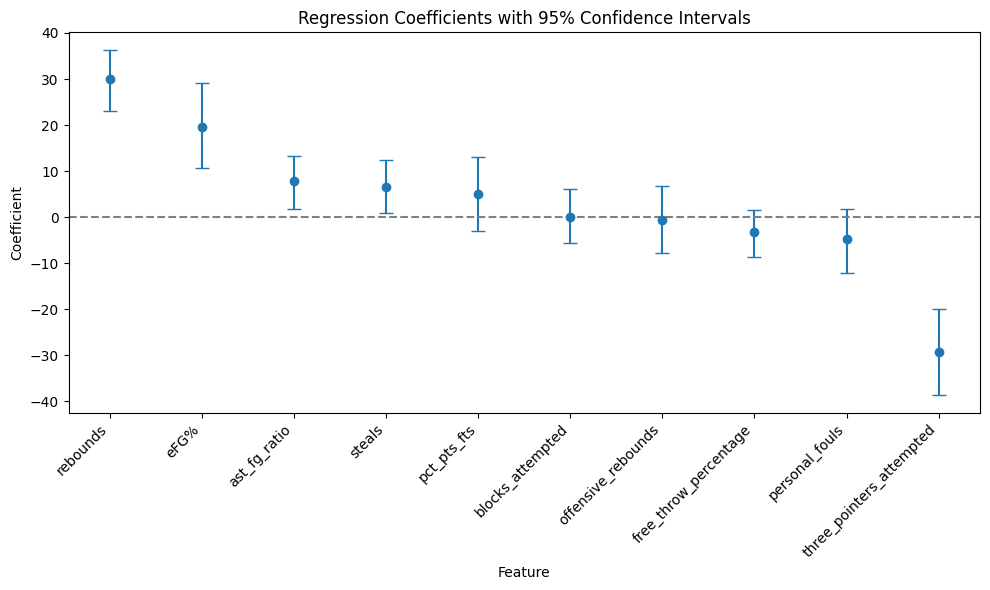

In [126]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_blocks_full)

In [127]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_blocks_full, blocks_feats_full, False)

A 68.781 unit increase in rebounds results in an approximate 8.859 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate 6.941 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 2.281 change in the target variable.
A 12.188 unit increase in steals results in an approximate 1.096 change in the target variable.
A 36.573 unit increase in three_pointers_attempted results in an approximate -1.631 change in the target variable.


In [128]:
# Continue with secondary feature regression analysis using personal_fouls as the target variable

In [129]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [130]:
# Drop the target variable from the features
pf_feats_full = df_feats_master.drop(['personal_fouls'], axis=1)

pf_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [131]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
pf_full_feature_matrix, pf_full_feat_str_correlations = gen_corr_matrix(pf_feats_full)

pf_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [132]:
# Define the target variable for the dataset
y_pf_full = df_feats_master['personal_fouls']

# Train the model for the dataset
results_pf_full, pf_feats_full = gen_lasso_model(pf_feats_full, y_pf_full)

Best Alpha: 0.05
Y Measurables: 
count     716.000000
mean     1668.815642
std       175.680398
min      1109.000000
25%      1562.500000
50%      1676.000000
75%      1786.000000
max      2189.000000
Name: personal_fouls, dtype: float64
Training RMSE: 124.3716469216882, Testing RMSE: 123.92838538436449
Training R^2: 0.4784636130489046, Testing R^2: 0.564853246430739
Non-zero Coefficients: 
pct_pts_fts                 55.568629
rebounds                    42.037809
three_point_percentage      30.691310
steals                      28.535031
offensive_rebounds          27.786683
ast_fg_ratio                25.580626
three_pointers_attempted     7.944535
blocks_attempted             6.680296
free_throw_percentage        3.639824
blocks                      -7.988187
eFG%                        -9.087628
ast_to_ratio               -56.479970
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.867298
1     three_point_percentage

In [133]:
# Drop the three_point_percentage feature to reduce vif scores
pf_feats_full = pf_feats_full.drop(['three_point_percentage'], axis=1)

pf_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   blocks_attempted          716 non-null    int64  
 7   ast_to_ratio              716 non-null    float64
 8   pct_pts_fts               716 non-null    float64
 9   ast_fg_ratio              716 non-null    float64
 10  eFG%                      716 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 61.7 KB


In [134]:
# Retrain the model 
results_pf_full, pf_feats_full = gen_lasso_model(pf_feats_full, y_pf_full)

Best Alpha: 0.1
Y Measurables: 
count     716.000000
mean     1668.815642
std       175.680398
min      1109.000000
25%      1562.500000
50%      1676.000000
75%      1786.000000
max      2189.000000
Name: personal_fouls, dtype: float64
Training RMSE: 126.47285510737568, Testing RMSE: 126.93697481424634
Training R^2: 0.4606924638040162, Testing R^2: 0.5434688110602292
Non-zero Coefficients: 
pct_pts_fts                 53.700328
rebounds                    46.146952
offensive_rebounds          27.055965
steals                      27.025775
ast_fg_ratio                25.756190
eFG%                        16.963580
free_throw_percentage        7.767162
blocks_attempted             2.880985
three_pointers_attempted    -7.587076
blocks                      -7.651997
ast_to_ratio               -57.567554
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.316266
1      free_throw_percentage  1.394149
2         offensive_reboun

In [135]:
# With feature selection finalized, create a series of regression coefficients
pf_full_coefficients = pd.Series(results_pf_full['non_zero_coefficients'])

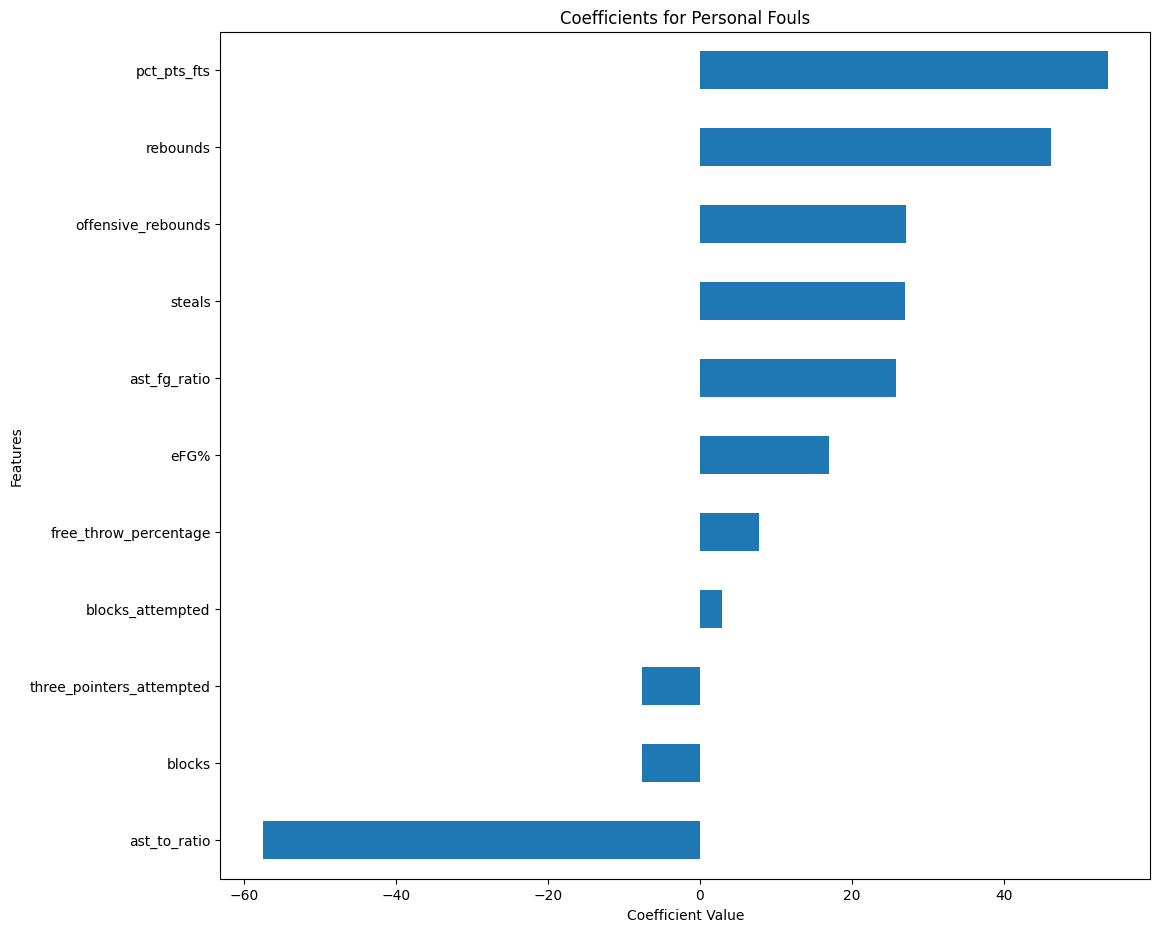

In [136]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(pf_full_coefficients, 'Personal Fouls')

In [137]:
# Generate bootstrap coefficients 
bootstrap_results_pf_full = gen_bootstrap_coefficients(
    results_pf_full['model'], results_pf_full['X'], results_pf_full['y'], results_pf_full['feature_names']
)

Average Y: 1668.8156424581005
Average Training RMSE: 124.64617189554899, Average Testing RMSE: 127.23339861082353
Average Training R^2: 0.4911900045048901, Average Testing R^2: 0.46214726058151406
Sorted Coefficients: 
                               Mean     StdDev   CI Lower   CI Upper
pct_pts_fts               57.198168   8.510525  41.077249  74.608905
rebounds                  47.006215   9.005000  29.484323  64.037765
steals                    36.203303   6.109858  24.069897  47.612711
offensive_rebounds        25.436874   9.160398   7.907969  42.987189
ast_fg_ratio              21.942599   6.682372   9.267113  35.949102
eFG%                      12.805748  11.278564  -8.833927  35.434790
free_throw_percentage      6.637311   6.523675  -5.998412  20.001175
blocks_attempted           2.183431   6.463306 -10.376276  15.155207
three_pointers_attempted  -7.168871  10.341002 -26.836178  12.184202
blocks                    -9.081100   6.376696 -21.861241   2.688032
ast_to_ratio          

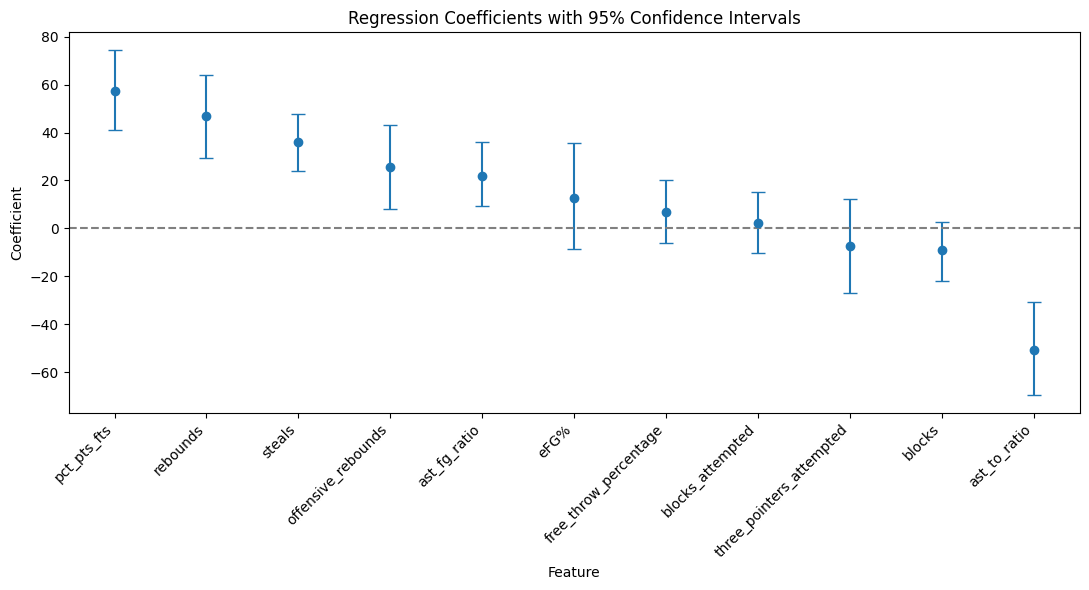

In [138]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_pf_full)

In [139]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_pf_full, pf_feats_full, False)

A 0.004 unit increase in pct_pts_fts results in an approximate 9.028 change in the target variable.
A 68.781 unit increase in rebounds results in an approximate 13.930 change in the target variable.
A 12.188 unit increase in steals results in an approximate 5.988 change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approximate 3.692 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 6.475 change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate -7.155 change in the target variable.


In [140]:
# Continue with secondary feature regression analysis using blocks_attempted as the target variable

In [141]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [142]:
# Drop the target variable from the features
ba_feats_full = df_feats_master.drop(['blocks_attempted'], axis=1)

ba_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   personal_fouls            716 non-null    int64  
 8   ast_to_ratio              716 non-null    float64
 9   pct_pts_fts               716 non-null    float64
 10  ast_fg_ratio              716 non-null    float64
 11  eFG%                      716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [143]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ba_full_feature_matrix, ba_full_feat_str_correlations = gen_corr_matrix(ba_feats_full)

ba_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [144]:
# Define the target variable for the dataset
y_ba_full = df_feats_master['blocks_attempted']

# Train the model for the dataset
results_ba_full, ba_feats_full = gen_lasso_model(ba_feats_full, y_ba_full)

Best Alpha: 0.1
Y Measurables: 
count    716.000000
mean     393.428771
std       59.046211
min      245.000000
25%      352.750000
50%      392.500000
75%      431.000000
max      565.000000
Name: blocks_attempted, dtype: float64
Training RMSE: 46.31723126013514, Testing RMSE: 48.62829474684663
Training R^2: 0.37878120501684, Testing R^2: 0.32209918676599747
Non-zero Coefficients: 
three_pointers_attempted    16.483828
offensive_rebounds          15.672872
ast_fg_ratio                 7.989085
free_throw_percentage        7.244882
rebounds                     7.042082
steals                       6.149613
personal_fouls               2.677288
blocks                       1.378127
pct_pts_fts                 -0.838433
three_point_percentage      -8.297317
ast_to_ratio               -15.021148
eFG%                       -15.517614
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  4.745160
1     three_point_percentage  1.8755

In [145]:
# Drop the three_point_percentage feature to reduce vif scores
ba_feats_full = ba_feats_full.drop(['three_point_percentage'], axis=1)

ba_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   free_throw_percentage     716 non-null    float64
 2   offensive_rebounds        716 non-null    int64  
 3   rebounds                  716 non-null    int64  
 4   steals                    716 non-null    int64  
 5   blocks                    716 non-null    int64  
 6   personal_fouls            716 non-null    int64  
 7   ast_to_ratio              716 non-null    float64
 8   pct_pts_fts               716 non-null    float64
 9   ast_fg_ratio              716 non-null    float64
 10  eFG%                      716 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 61.7 KB


In [146]:
# Retrain the model
results_ba_full, ba_feats_full = gen_lasso_model(ba_feats_full, y_ba_full)

Best Alpha: 0.1
Y Measurables: 
count    716.000000
mean     393.428771
std       59.046211
min      245.000000
25%      352.750000
50%      392.500000
75%      431.000000
max      565.000000
Name: blocks_attempted, dtype: float64
Training RMSE: 46.71440474864199, Testing RMSE: 48.79086178036805
Training R^2: 0.3680815366782404, Testing R^2: 0.31755909197846544
Non-zero Coefficients: 
three_pointers_attempted    21.160133
offensive_rebounds          16.385672
ast_fg_ratio                 8.275557
steals                       6.908422
rebounds                     6.387475
free_throw_percentage        6.317350
blocks                       1.313672
personal_fouls               1.186263
ast_to_ratio               -15.467144
eFG%                       -23.089590
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.482958
1      free_throw_percentage  1.276943
2         offensive_rebounds  2.985240
3                   rebounds  2.

In [147]:
# With feature selection finalized, create a series of regression coefficients
ba_full_coefficients = pd.Series(results_ba_full['non_zero_coefficients'])

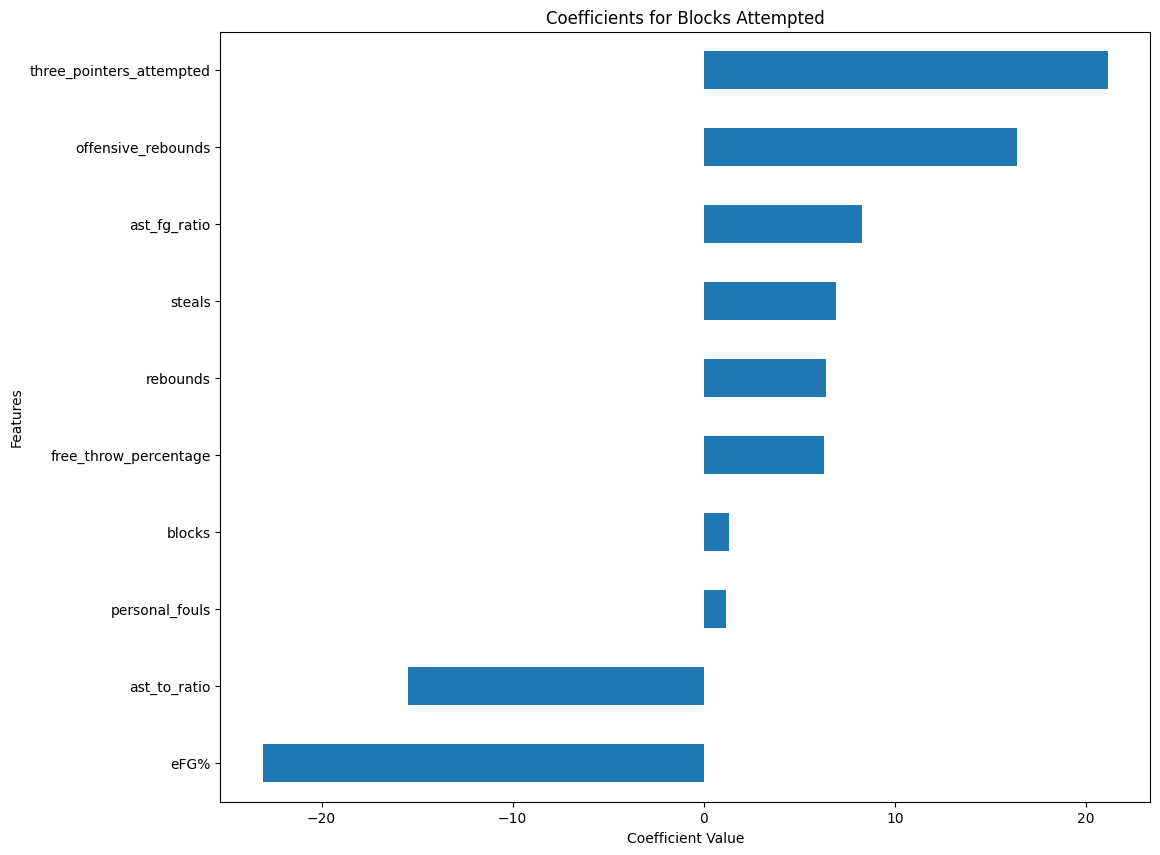

In [148]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ba_full_coefficients, 'Blocks Attempted')

In [149]:
# Generate bootstrap coefficients 
bootstrap_results_ba_full = gen_bootstrap_coefficients(
    results_ba_full['model'], results_ba_full['X'], results_ba_full['y'], results_ba_full['feature_names']
)

Average Y: 393.4287709497207
Average Training RMSE: 46.52669395013972, Average Testing RMSE: 47.336034797067114
Average Training R^2: 0.37513947106018386, Average Testing R^2: 0.3414692015639939
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
three_pointers_attempted  20.744751  3.803522  13.294363  28.268262
offensive_rebounds        15.484460  3.551658   8.092282  22.596782
ast_fg_ratio               8.622818  2.525250   3.918150  13.780557
steals                     7.844836  2.238049   3.568523  12.091370
free_throw_percentage      5.421109  2.454614   0.241868  10.035119
rebounds                   5.175160  3.249990  -0.516601  11.661246
personal_fouls             1.174741  2.472370  -3.727971   6.221383
blocks                     0.074585  2.271218  -4.439969   4.616819
ast_to_ratio             -15.248495  3.895408 -22.992639  -7.492228
eFG%                     -24.506761  4.264118 -32.837619 -16.483188


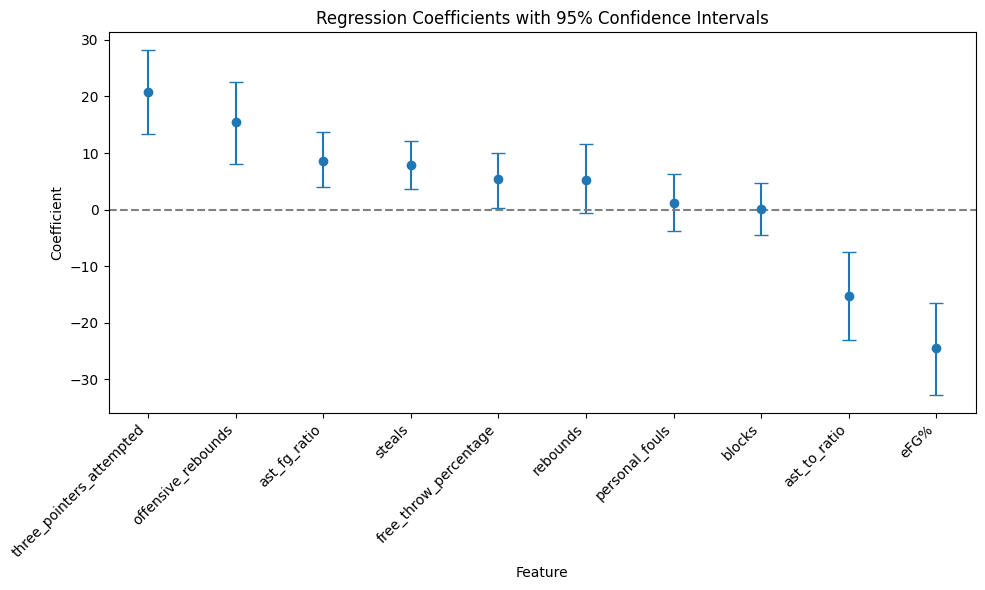

In [150]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ba_full)

In [151]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ba_full, ba_feats_full, False)

A 36.573 unit increase in three_pointers_attempted results in an approximate 1.154 change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approximate 2.247 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 2.545 change in the target variable.
A 12.188 unit increase in steals results in an approximate 1.298 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate 2.753 change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate -2.151 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate -8.720 change in the target variable.


In [152]:
# Continue with secondary feature regression analysis using three_pointers_attempted as the target variable

In [153]:
# Check the df_feats_master DataFrame
df_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  716 non-null    int64  
 1   three_point_percentage    716 non-null    float64
 2   free_throw_percentage     716 non-null    float64
 3   offensive_rebounds        716 non-null    int64  
 4   rebounds                  716 non-null    int64  
 5   steals                    716 non-null    int64  
 6   blocks                    716 non-null    int64  
 7   blocks_attempted          716 non-null    int64  
 8   personal_fouls            716 non-null    int64  
 9   ast_to_ratio              716 non-null    float64
 10  pct_pts_fts               716 non-null    float64
 11  ast_fg_ratio              716 non-null    float64
 12  eFG%                      716 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 72.8 KB


In [154]:
# Drop the target variable from the features
tpa_feats_full = df_feats_master.drop(['three_pointers_attempted'], axis=1)

tpa_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   three_point_percentage  716 non-null    float64
 1   free_throw_percentage   716 non-null    float64
 2   offensive_rebounds      716 non-null    int64  
 3   rebounds                716 non-null    int64  
 4   steals                  716 non-null    int64  
 5   blocks                  716 non-null    int64  
 6   blocks_attempted        716 non-null    int64  
 7   personal_fouls          716 non-null    int64  
 8   ast_to_ratio            716 non-null    float64
 9   pct_pts_fts             716 non-null    float64
 10  ast_fg_ratio            716 non-null    float64
 11  eFG%                    716 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 67.2 KB


In [155]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
tpa_full_feature_matrix, tpa_full_feat_str_correlations = gen_corr_matrix(tpa_feats_full)

tpa_full_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [156]:
# Drop the eFG% feature from the dataset
tpa_feats_full = tpa_feats_full.drop(['eFG%'], axis=1)

tpa_feats_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   three_point_percentage  716 non-null    float64
 1   free_throw_percentage   716 non-null    float64
 2   offensive_rebounds      716 non-null    int64  
 3   rebounds                716 non-null    int64  
 4   steals                  716 non-null    int64  
 5   blocks                  716 non-null    int64  
 6   blocks_attempted        716 non-null    int64  
 7   personal_fouls          716 non-null    int64  
 8   ast_to_ratio            716 non-null    float64
 9   pct_pts_fts             716 non-null    float64
 10  ast_fg_ratio            716 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 61.7 KB


In [157]:
# Define the target variable for the dataset
y_tpa_full = df_feats_master['three_pointers_attempted']

# Train the model for the dataset
results_tpa_full, tpa_feats_full = gen_lasso_model(tpa_feats_full, y_tpa_full)

Best Alpha: 0.1
Y Measurables: 
count     716.000000
mean     1828.652235
std       658.066269
min       641.000000
25%      1302.500000
50%      1662.500000
75%      2367.250000
max      3721.000000
Name: three_pointers_attempted, dtype: float64
Training RMSE: 377.8858308735927, Testing RMSE: 380.274682126858
Training R^2: 0.6542730924027779, Testing R^2: 0.7131750679001625
Non-zero Coefficients: 
rebounds                  262.846884
ast_to_ratio              125.829783
blocks_attempted           47.372792
free_throw_percentage      38.269536
steals                     24.912779
personal_fouls              7.154777
three_point_percentage    -16.595407
ast_fg_ratio              -57.191276
blocks                    -62.691639
pct_pts_fts              -245.582167
offensive_rebounds       -269.431433
dtype: float64
Variance Inflation Factors: 
                   feature       vif
0   three_point_percentage  1.444536
1    free_throw_percentage  1.409655
2       offensive_rebounds  2.387652

In [158]:
# With feature selection finalized, create a series of regression coefficients
tpa_full_coefficients = pd.Series(results_tpa_full['non_zero_coefficients'])

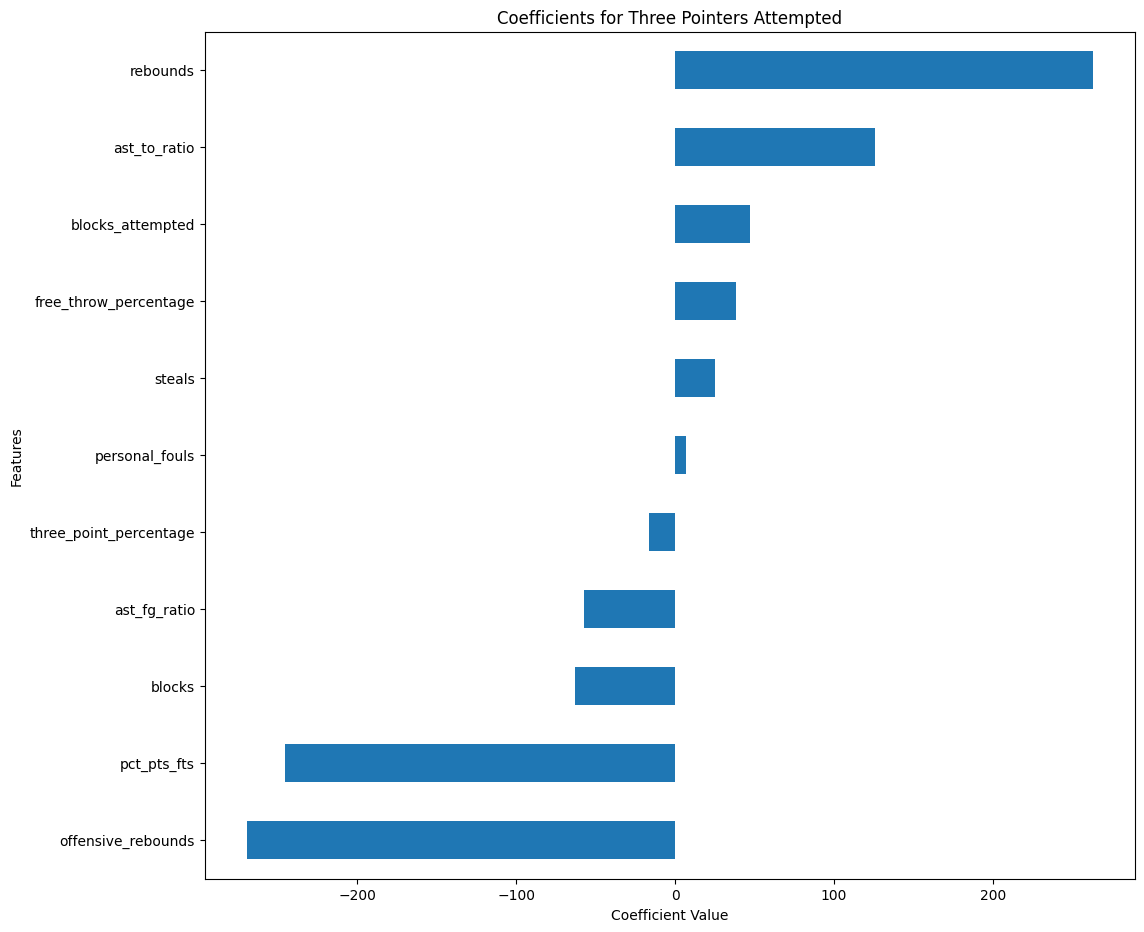

In [159]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(tpa_full_coefficients, 'Three Pointers Attempted')

In [160]:
# Generate bootstrap coefficients 
bootstrap_results_tpa_full = gen_bootstrap_coefficients(
    results_tpa_full['model'], results_tpa_full['X'], results_tpa_full['y'], results_tpa_full['feature_names']
)

Average Y: 1828.6522346368715
Average Training RMSE: 373.0571497256023, Average Testing RMSE: 380.8308596731194
Average Training R^2: 0.6776431252202871, Average Testing R^2: 0.660080398836074
Sorted Coefficients: 
                              Mean     StdDev    CI Lower    CI Upper
rebounds                288.757971  21.588414  248.821578  332.941025
ast_to_ratio            126.270416  29.714679   65.308407  184.169327
blocks_attempted         40.664043  18.204101    4.876952   75.037510
free_throw_percentage    32.697253  18.891646   -4.768934   68.477762
steals                   19.645172  20.156820  -18.320069   61.071668
personal_fouls            5.359946  21.733269  -37.219098   48.304066
three_point_percentage  -23.687720  17.760686  -59.530261    8.502216
ast_fg_ratio            -60.590439  20.980905 -100.366920  -19.140803
blocks                  -77.528718  15.965698 -107.794454  -45.676217
pct_pts_fts            -255.297292  24.361572 -305.079915 -208.304012
offensive_rebou

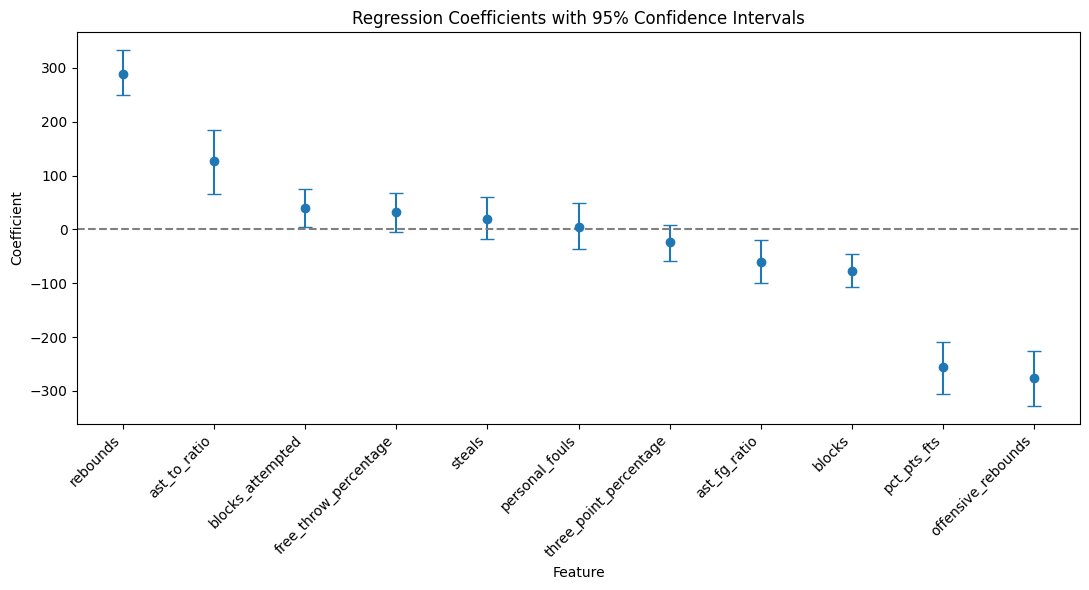

In [161]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_tpa_full)

In [162]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_tpa_full, tpa_feats_full, False)

A 68.781 unit increase in rebounds results in an approximate 85.573 change in the target variable.
A 0.032 unit increase in ast_to_ratio results in an approximate 17.811 change in the target variable.
A 7.869 unit increase in blocks_attempted results in an approximate 5.423 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -17.880 change in the target variable.
A 7.869 unit increase in blocks results in an approximate -9.111 change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate -40.295 change in the target variable.
A 17.627 unit increase in offensive_rebounds results in an approximate -39.916 change in the target variable.
